In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import h5py
from pykeops.torch import LazyTensor, generic_sum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from scipy.special import gamma, kv
from scipy import interpolate

import os.path
import sys
sys.path.append("../..")
from losses import squared_error, relative_error
from rkhs_functions import RKHSFunction
from constraints import Symmetric, FlipSymmetric
from helper import trapezoid_rule, standard_deviation

from training_functions import train_rkhs_pde

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
###############################################################################
#   Generate Helmholtz PDE Forcings and Solutions
###############################################################################

mx_train = 100
kernel_width_train = 0.01

data = h5py.File("../../generate_data/helmholtz_gaussianKLE1D_dirbc.hdf5", "r")
x_train = data[f"mesh{mx_train}"].attrs["mesh"][0]

num_train = 100
fs_train = data[f"mesh{mx_train}"][f"kernelwidth{kernel_width_train}"]["forcings"][:num_train, :]
us_train_clean = data[f"mesh{mx_train}"][f"kernelwidth{kernel_width_train}"]["solutions"][:num_train, :]

x_train = torch.from_numpy(x_train).type(tensor)
fs_train = torch.from_numpy(fs_train).type(tensor)
us_train_clean = torch.from_numpy(us_train_clean).type(tensor)

# add noise to solutions at a given SNR
sigma = 0
us_train = us_train_clean + sigma * standard_deviation(us_train_clean) * torch.randn(num_train, mx_train).type(tensor)

L = 1
left_dbc = -0.1
right_dbc = 0.1
w = 20

# whether bias term exists or not
bias = True

# true Green's kernel
mx_true = 500
x_true = torch.linspace(0, L, mx_true).type(tensor)
X, Y = torch.meshgrid(x_true, x_true, indexing="ij")
G_true = torch.zeros((mx_true, mx_true)).type(tensor)
if np.abs(w) < 1e-15:
    G_true = (X + Y - torch.abs(Y - X)) / 2 - X * Y
else:
    modes = 100
    for k in range(1, modes):
        p = math.pi*k/L
        G_true += 2/L * torch.sin(p*X) * torch.sin(p*Y) / (p**2 - w**2)

beta_true = None
if bias:
    # true bias term
    beta_true = (right_dbc - left_dbc) * x_true + left_dbc
    if np.abs(w) >= 1e-15:
        A = (right_dbc - left_dbc * math.cos(w)) / math.sin(w)
        B = left_dbc
        beta_true = A*torch.sin(w*x_true) + B*torch.cos(w*x_true)

# compute the signal to noise of the solutions on the train data
snr = torch.sqrt(torch.mean(torch.sum(us_train**2, dim=0)) / torch.mean(torch.sum((us_train-us_train_clean)**2, dim=0)))
print('Signal to Noise Ratio: ' + str(snr))

Signal to Noise Ratio: tensor(inf, device='cuda:0')


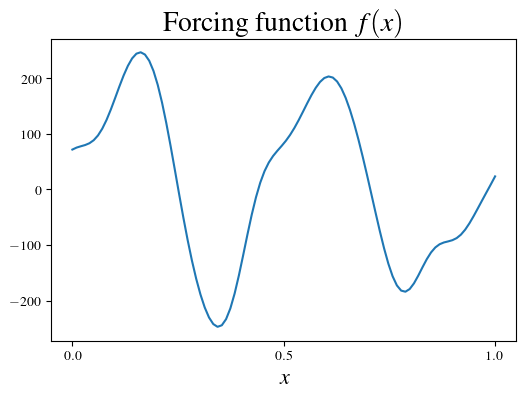

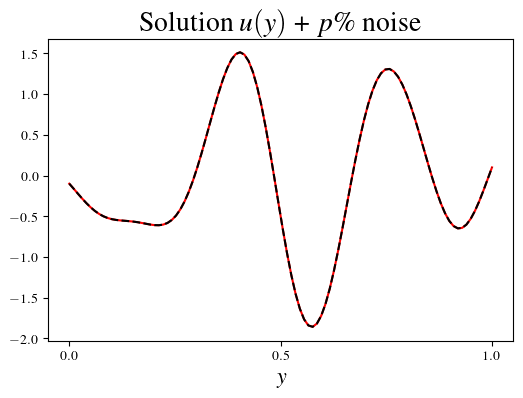

In [45]:
i = 0

plt.figure(dpi=100)
plt.plot(x_train.cpu(), fs_train[i, :].cpu())
plt.xlabel("$x$", fontsize=16)
plt.xticks([0, 0.5, 1])
plt.title("Forcing function $f(x)$", fontsize=20)
plt.savefig("../../figures/helmholtz_forcing.png")
plt.show()

plt.figure(dpi=100)
plt.plot(x_train.cpu(), us_train[0, :].cpu(), color="red")
plt.plot(x_train.cpu(), us_train_clean[0, :].cpu(), linestyle="dashed", color="black")
plt.xlabel("$y$", fontsize=16)
plt.xticks([0, 0.5, 1])
plt.title("Solution $u(y)$ + $p\%$ noise", fontsize=20)
plt.savefig("../../figures/helmholtz_solution.png")
plt.show()

In [62]:
mx_weight = 100
x_weight = torch.linspace(x_train.min(), x_train.max(), mx_weight).type(tensor)

kernel = "Matern5/2" #"Linear"
kernel_width = 2/mx_weight

lmbda = 1e-5

epochs = 1000
plotting_freq = 10
batch_size = 100
learning_rate = 1e-2

ind_divisor = 0
greens_out_meshes = (x_train, x_train)
greens_out_meshes_true = (x_true, x_true)
greens_weight_meshes = (x_weight, x_weight)

bias_out_meshes = (x_train,)
bias_out_meshes_true = (x_true,)
bias_weight_meshes = (x_weight,)

greens_weight_parametrizations = []#Symmetric((mx_weight, mx_weight), 0, 1), FlipSymmetric((mx_weight, mx_weight), 0, 1)]
bias_weight_parametrizations = []

def greens_transform_output(G, meshes):
    #sizes = [len(x) for x in meshes]
    #G = greens_weight_parametrizations[0](G, dims=sizes, tri="both")
    #G = greens_weight_parametrizations[1](G, dims=sizes, direction="both")
    return G

bias_transform_output = None

def plotting_function(us_train_hat):
    example_ind = 0
    u_train = us_train[example_ind, :].cpu()
    u_clean = us_train_clean[example_ind, :].cpu()
    u_hat = us_train_hat[example_ind, :].cpu()
    plt.figure(1)
    plt.title('Training Output Example', fontweight='bold')
    plt.plot(x_train.cpu(), u_train, label='$u$ train')
    plt.plot(x_train.cpu(), u_clean, label='$u$ clean', color="k")
    plt.plot(x_train.cpu(), u_hat.detach(), '--', label='$\widehat{u}$ pred')
    plt.xlabel('x')
    plt.legend(loc='upper right')
    plt.show()

In [63]:
f_size = math.prod([len(x) for x in greens_out_meshes[:ind_divisor+1]])
f_size_true = math.prod([len(x) for x in greens_out_meshes_true[:ind_divisor+1]])
f_quadrature = trapezoid_rule(greens_out_meshes[:ind_divisor+1]).flatten()
u_size = math.prod([len(x) for x in greens_out_meshes[ind_divisor+1:]])
u_size_true = math.prod([len(x) for x in greens_out_meshes_true[ind_divisor+1:]])
u_quadrature = trapezoid_rule(greens_out_meshes[ind_divisor+1:]).flatten()

Green's Function Learning Rate: 0.01
Bias Term Learning Rate: 0.01
Epoch 1 Relative Error 1.9417444467544556
Epoch 2 Relative Error 1.570089340209961
Epoch 3 Relative Error 1.1722265481948853
Epoch 4 Relative Error 1.0431839227676392
Epoch 5 Relative Error 1.1974806785583496
Epoch 6 Relative Error 1.1539055109024048
Epoch 7 Relative Error 0.932086169719696
Epoch 8 Relative Error 0.7831001281738281
Epoch 9 Relative Error 0.7926971912384033


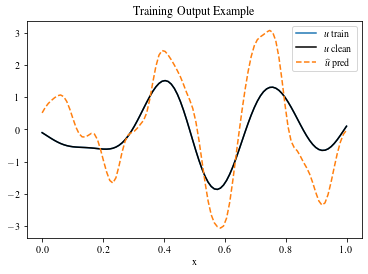

Epoch 10 Relative Error 0.8218083381652832
Epoch 11 Relative Error 0.8105950951576233
Epoch 12 Relative Error 0.7451000809669495
Epoch 13 Relative Error 0.64483243227005
Epoch 14 Relative Error 0.5804997682571411
Epoch 15 Relative Error 0.5818014740943909
Epoch 16 Relative Error 0.5868528485298157
Epoch 17 Relative Error 0.5606789588928223
Epoch 18 Relative Error 0.5244849324226379
Epoch 19 Relative Error 0.4939914345741272


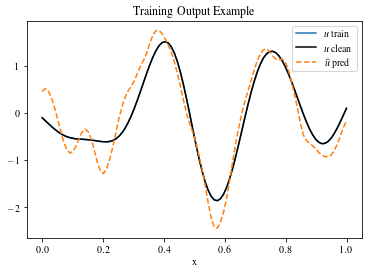

Epoch 20 Relative Error 0.46071210503578186
Epoch 21 Relative Error 0.42504385113716125
Epoch 22 Relative Error 0.40154382586479187
Epoch 23 Relative Error 0.4006306231021881
Epoch 24 Relative Error 0.40924009680747986
Epoch 25 Relative Error 0.3952412009239197
Epoch 26 Relative Error 0.3465408384799957
Epoch 27 Relative Error 0.3013964593410492
Epoch 28 Relative Error 0.303603857755661
Epoch 29 Relative Error 0.3223913908004761


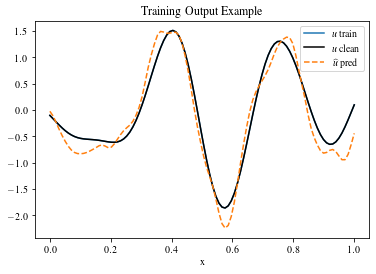

Epoch 30 Relative Error 0.31310907006263733
Epoch 31 Relative Error 0.27664750814437866
Epoch 32 Relative Error 0.24186404049396515
Epoch 33 Relative Error 0.23226067423820496
Epoch 34 Relative Error 0.23930993676185608
Epoch 35 Relative Error 0.24032391607761383
Epoch 36 Relative Error 0.22327788174152374
Epoch 37 Relative Error 0.19076445698738098
Epoch 38 Relative Error 0.16936033964157104
Epoch 39 Relative Error 0.18303701281547546


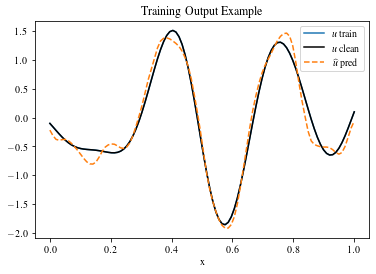

Epoch 40 Relative Error 0.1968710720539093
Epoch 41 Relative Error 0.17769959568977356
Epoch 42 Relative Error 0.14235667884349823
Epoch 43 Relative Error 0.13364414870738983
Epoch 44 Relative Error 0.14963582158088684
Epoch 45 Relative Error 0.15756617486476898
Epoch 46 Relative Error 0.14283594489097595
Epoch 47 Relative Error 0.11286589503288269
Epoch 48 Relative Error 0.10437292605638504
Epoch 49 Relative Error 0.1220557689666748


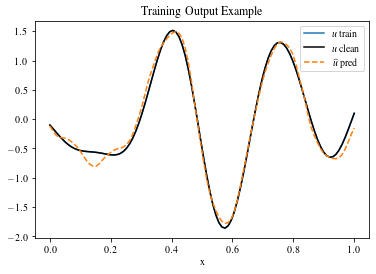

Epoch 50 Relative Error 0.12248454242944717
Epoch 51 Relative Error 0.10049229115247726
Epoch 52 Relative Error 0.0903400108218193
Epoch 53 Relative Error 0.09819028526544571
Epoch 54 Relative Error 0.09643305838108063
Epoch 55 Relative Error 0.0853423997759819
Epoch 56 Relative Error 0.07847601175308228
Epoch 57 Relative Error 0.07724788784980774
Epoch 58 Relative Error 0.07603715360164642
Epoch 59 Relative Error 0.0722634494304657


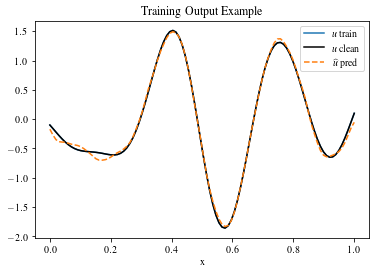

Epoch 60 Relative Error 0.06632720679044724
Epoch 61 Relative Error 0.06250035017728806
Epoch 62 Relative Error 0.06147158518433571
Epoch 63 Relative Error 0.057733505964279175
Epoch 64 Relative Error 0.05440955236554146
Epoch 65 Relative Error 0.055425457656383514
Epoch 66 Relative Error 0.05295176804065704
Epoch 67 Relative Error 0.04676167666912079
Epoch 68 Relative Error 0.04521903395652771
Epoch 69 Relative Error 0.04567057639360428


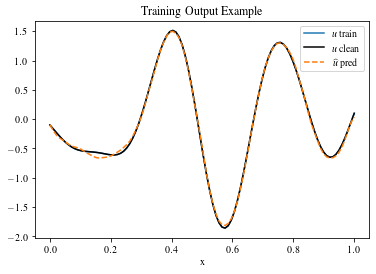

Epoch 70 Relative Error 0.04396383836865425
Epoch 71 Relative Error 0.040834031999111176
Epoch 72 Relative Error 0.037544768303632736
Epoch 73 Relative Error 0.037493884563446045
Epoch 74 Relative Error 0.03847252205014229
Epoch 75 Relative Error 0.03528386354446411
Epoch 76 Relative Error 0.03107462450861931
Epoch 77 Relative Error 0.0314330980181694
Epoch 78 Relative Error 0.032187219709157944
Epoch 79 Relative Error 0.029542407020926476


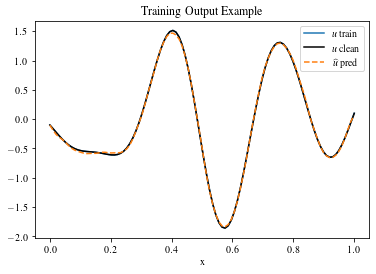

Epoch 80 Relative Error 0.02768900990486145
Epoch 81 Relative Error 0.027929166331887245
Epoch 82 Relative Error 0.027646087110042572
Epoch 83 Relative Error 0.0272878035902977
Epoch 84 Relative Error 0.02519187517464161
Epoch 85 Relative Error 0.023288767784833908
Epoch 86 Relative Error 0.024190628901124
Epoch 87 Relative Error 0.023678524419665337
Epoch 88 Relative Error 0.021951938048005104
Epoch 89 Relative Error 0.021502969786524773


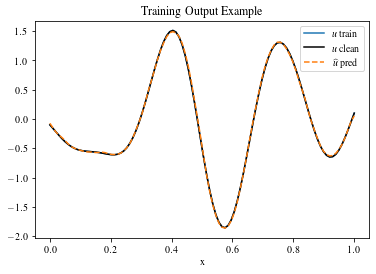

Epoch 90 Relative Error 0.021740678697824478
Epoch 91 Relative Error 0.021462956443428993
Epoch 92 Relative Error 0.02036309614777565
Epoch 93 Relative Error 0.019534433260560036
Epoch 94 Relative Error 0.019415393471717834
Epoch 95 Relative Error 0.01918339543044567
Epoch 96 Relative Error 0.018688086420297623
Epoch 97 Relative Error 0.018339402973651886
Epoch 98 Relative Error 0.018047645688056946
Epoch 99 Relative Error 0.018085328862071037


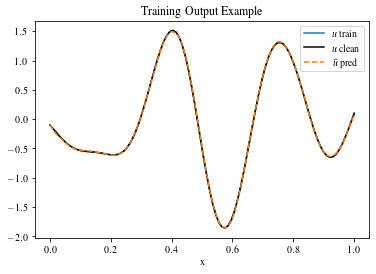

Epoch 100 Relative Error 0.017887860536575317
Epoch 101 Relative Error 0.01709233783185482
Epoch 102 Relative Error 0.01665952056646347
Epoch 103 Relative Error 0.016619369387626648
Epoch 104 Relative Error 0.016579143702983856
Epoch 105 Relative Error 0.016330109909176826
Epoch 106 Relative Error 0.01594281755387783
Epoch 107 Relative Error 0.01580977253615856
Epoch 108 Relative Error 0.015693221241235733
Epoch 109 Relative Error 0.015443013980984688


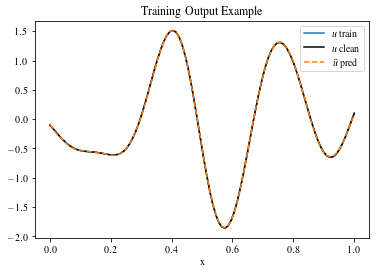

Epoch 110 Relative Error 0.015186689794063568
Epoch 111 Relative Error 0.015034289099276066
Epoch 112 Relative Error 0.014928646385669708
Epoch 113 Relative Error 0.014715181663632393
Epoch 114 Relative Error 0.01455784123390913
Epoch 115 Relative Error 0.014535876922309399
Epoch 116 Relative Error 0.014484653249382973
Epoch 117 Relative Error 0.014277932234108448
Epoch 118 Relative Error 0.014109709300100803
Epoch 119 Relative Error 0.014047011733055115


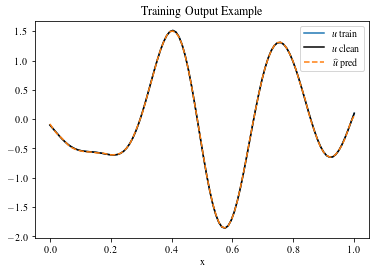

Epoch 120 Relative Error 0.013941441662609577
Epoch 121 Relative Error 0.013831046409904957
Epoch 122 Relative Error 0.013722315430641174
Epoch 123 Relative Error 0.0136645482853055
Epoch 124 Relative Error 0.013624940998852253
Epoch 125 Relative Error 0.013462785631418228
Epoch 126 Relative Error 0.013321016915142536
Epoch 127 Relative Error 0.013281082734465599
Epoch 128 Relative Error 0.013196112588047981
Epoch 129 Relative Error 0.01308373548090458


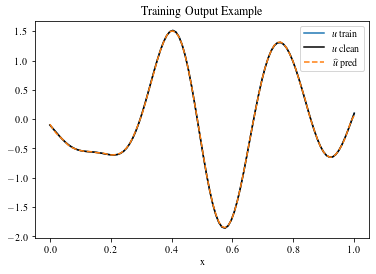

Epoch 130 Relative Error 0.013002791441977024
Epoch 131 Relative Error 0.012959797866642475
Epoch 132 Relative Error 0.01291485782712698
Epoch 133 Relative Error 0.012833753600716591
Epoch 134 Relative Error 0.012763068079948425
Epoch 135 Relative Error 0.012682805769145489
Epoch 136 Relative Error 0.01259872131049633
Epoch 137 Relative Error 0.012542088516056538
Epoch 138 Relative Error 0.012492275796830654
Epoch 139 Relative Error 0.012435424141585827


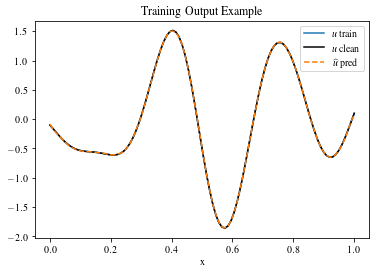

Epoch 140 Relative Error 0.012368234805762768
Epoch 141 Relative Error 0.012308175675570965
Epoch 142 Relative Error 0.012251061387360096
Epoch 143 Relative Error 0.012188310734927654
Epoch 144 Relative Error 0.012130414135754108
Epoch 145 Relative Error 0.012072134763002396
Epoch 146 Relative Error 0.012019087560474873
Epoch 147 Relative Error 0.01197139173746109
Epoch 148 Relative Error 0.011919859796762466
Epoch 149 Relative Error 0.011866975575685501


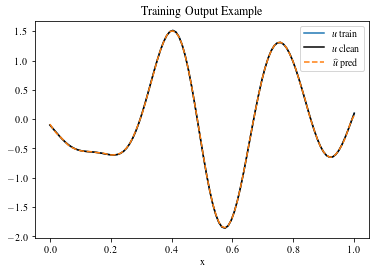

Epoch 150 Relative Error 0.011816875077784061
Epoch 151 Relative Error 0.011758788488805294
Epoch 152 Relative Error 0.011697006411850452
Epoch 153 Relative Error 0.011643202975392342
Epoch 154 Relative Error 0.011599492281675339
Epoch 155 Relative Error 0.011561553925275803
Epoch 156 Relative Error 0.011516640894114971
Epoch 157 Relative Error 0.011464412324130535
Epoch 158 Relative Error 0.01141610462218523
Epoch 159 Relative Error 0.011369703337550163


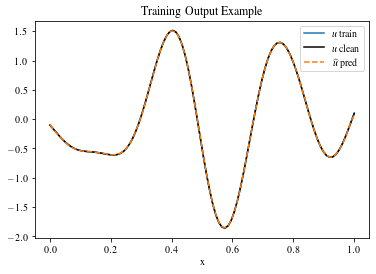

Epoch 160 Relative Error 0.011320862919092178
Epoch 161 Relative Error 0.011278754100203514
Epoch 162 Relative Error 0.01124005950987339
Epoch 163 Relative Error 0.011194129474461079
Epoch 164 Relative Error 0.011144262738525867
Epoch 165 Relative Error 0.011099901981651783
Epoch 166 Relative Error 0.011061400175094604
Epoch 167 Relative Error 0.011020383797585964
Epoch 168 Relative Error 0.010975288227200508
Epoch 169 Relative Error 0.010932235978543758


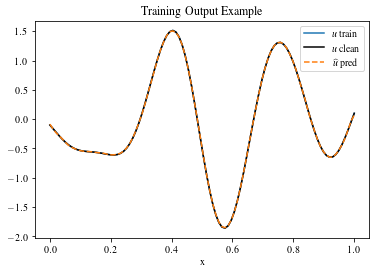

Epoch 170 Relative Error 0.010891974903643131
Epoch 171 Relative Error 0.010852452367544174
Epoch 172 Relative Error 0.01081160455942154
Epoch 173 Relative Error 0.010770418681204319
Epoch 174 Relative Error 0.010730616748332977
Epoch 175 Relative Error 0.010692710988223553
Epoch 176 Relative Error 0.010655614547431469
Epoch 177 Relative Error 0.010618146508932114
Epoch 178 Relative Error 0.010580236092209816
Epoch 179 Relative Error 0.010541901923716068


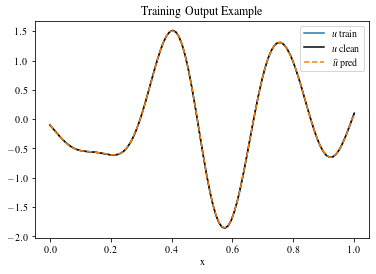

Epoch 180 Relative Error 0.010504037141799927
Epoch 181 Relative Error 0.010467223823070526
Epoch 182 Relative Error 0.010431217029690742
Epoch 183 Relative Error 0.01039554551243782
Epoch 184 Relative Error 0.010359557345509529
Epoch 185 Relative Error 0.010323792695999146
Epoch 186 Relative Error 0.010287961922585964
Epoch 187 Relative Error 0.010252535343170166
Epoch 188 Relative Error 0.010218363255262375
Epoch 189 Relative Error 0.010185467079281807


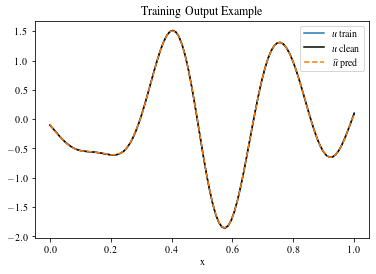

Epoch 190 Relative Error 0.010152640752494335
Epoch 191 Relative Error 0.01011862326413393
Epoch 192 Relative Error 0.010083786211907864
Epoch 193 Relative Error 0.01004968211054802
Epoch 194 Relative Error 0.010017168708145618
Epoch 195 Relative Error 0.009985438548028469
Epoch 196 Relative Error 0.00995351281017065
Epoch 197 Relative Error 0.009921571239829063
Epoch 198 Relative Error 0.009890018031001091
Epoch 199 Relative Error 0.00985864270478487


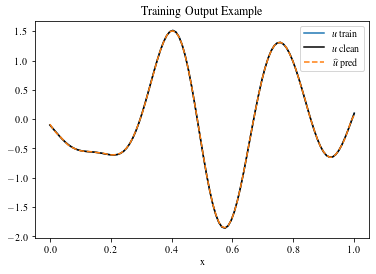

Epoch 200 Relative Error 0.009827051311731339
Epoch 201 Relative Error 0.009795784018933773
Epoch 202 Relative Error 0.009765546768903732
Epoch 203 Relative Error 0.009735960513353348
Epoch 204 Relative Error 0.009705998003482819
Epoch 205 Relative Error 0.009675583802163601
Epoch 206 Relative Error 0.009645622223615646
Epoch 207 Relative Error 0.009616412222385406
Epoch 208 Relative Error 0.00958755798637867
Epoch 209 Relative Error 0.009558708406984806


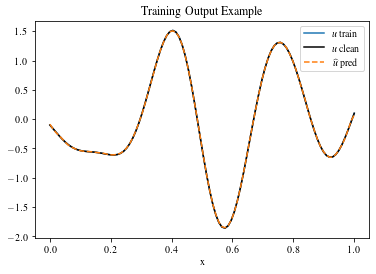

Epoch 210 Relative Error 0.009529942646622658
Epoch 211 Relative Error 0.009501321241259575
Epoch 212 Relative Error 0.0094728609547019
Epoch 213 Relative Error 0.009444772265851498
Epoch 214 Relative Error 0.009417148306965828
Epoch 215 Relative Error 0.009389803744852543
Epoch 216 Relative Error 0.009362584911286831
Epoch 217 Relative Error 0.009335547685623169
Epoch 218 Relative Error 0.00930856168270111
Epoch 219 Relative Error 0.009281597100198269


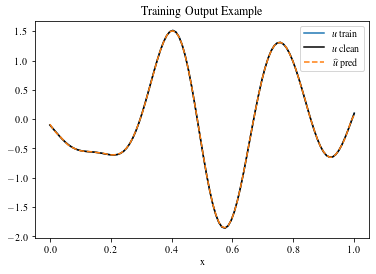

Epoch 220 Relative Error 0.00925495009869337
Epoch 221 Relative Error 0.009228747338056564
Epoch 222 Relative Error 0.009202632121741772
Epoch 223 Relative Error 0.009176607243716717
Epoch 224 Relative Error 0.009150982834398746
Epoch 225 Relative Error 0.009125687181949615
Epoch 226 Relative Error 0.009100258350372314
Epoch 227 Relative Error 0.009074871428310871
Epoch 228 Relative Error 0.009049869142472744
Epoch 229 Relative Error 0.009025275707244873


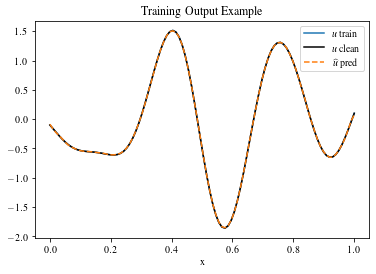

Epoch 230 Relative Error 0.009000660851597786
Epoch 231 Relative Error 0.008976218290627003
Epoch 232 Relative Error 0.008951889351010323
Epoch 233 Relative Error 0.008927974849939346
Epoch 234 Relative Error 0.008903994224965572
Epoch 235 Relative Error 0.008880526758730412
Epoch 236 Relative Error 0.00885668583214283
Epoch 237 Relative Error 0.008833704516291618
Epoch 238 Relative Error 0.008810093626379967
Epoch 239 Relative Error 0.008788574486970901


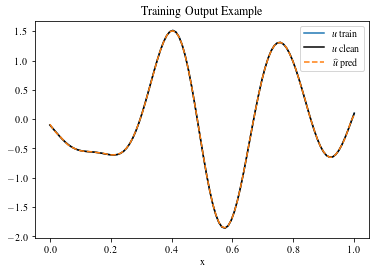

Epoch 240 Relative Error 0.008765777572989464
Epoch 241 Relative Error 0.00874798372387886
Epoch 242 Relative Error 0.008729689754545689
Epoch 243 Relative Error 0.008728953078389168
Epoch 244 Relative Error 0.00874229148030281
Epoch 245 Relative Error 0.008833457715809345
Epoch 246 Relative Error 0.009050491265952587
Epoch 247 Relative Error 0.009666957892477512
Epoch 248 Relative Error 0.011045030318200588
Epoch 249 Relative Error 0.014133816584944725


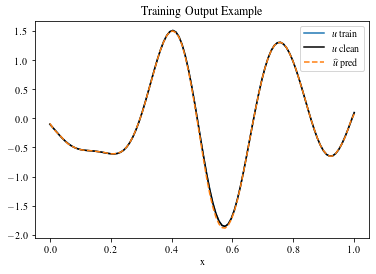

Epoch 250 Relative Error 0.02003900706768036
Epoch 251 Relative Error 0.030813727527856827
Epoch 252 Relative Error 0.049148861318826675
Epoch 253 Relative Error 0.07802561670541763
Epoch 254 Relative Error 0.11062987148761749
Epoch 255 Relative Error 0.12029798328876495
Epoch 256 Relative Error 0.07985049486160278
Epoch 257 Relative Error 0.01425679586827755
Epoch 258 Relative Error 0.07243108004331589
Epoch 259 Relative Error 0.09211678057909012


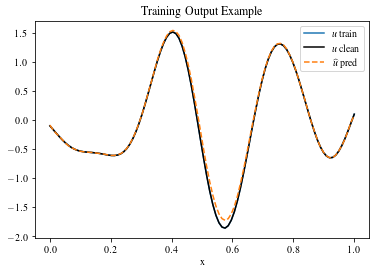

Epoch 260 Relative Error 0.051525574177503586
Epoch 261 Relative Error 0.025601999834179878
Epoch 262 Relative Error 0.07175901532173157
Epoch 263 Relative Error 0.06517981737852097
Epoch 264 Relative Error 0.016935795545578003
Epoch 265 Relative Error 0.04642024636268616
Epoch 266 Relative Error 0.06224048510193825
Epoch 267 Relative Error 0.0323333665728569
Epoch 268 Relative Error 0.024745428934693336
Epoch 269 Relative Error 0.05181330442428589


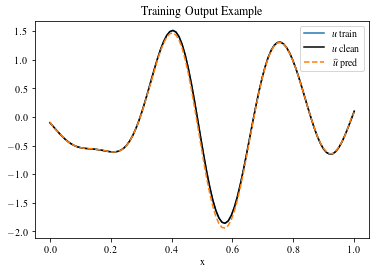

Epoch 270 Relative Error 0.04014906659722328
Epoch 271 Relative Error 0.013164379633963108
Epoch 272 Relative Error 0.03848212957382202
Epoch 273 Relative Error 0.04114754498004913
Epoch 274 Relative Error 0.017369158565998077
Epoch 275 Relative Error 0.024981075897812843
Epoch 276 Relative Error 0.03729518502950668
Epoch 277 Relative Error 0.024104570969939232
Epoch 278 Relative Error 0.013972209766507149
Epoch 279 Relative Error 0.029966866597533226


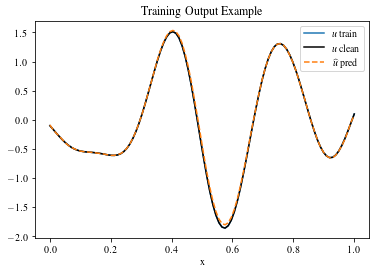

Epoch 280 Relative Error 0.0275415126234293
Epoch 281 Relative Error 0.011441944167017937
Epoch 282 Relative Error 0.020670318976044655
Epoch 283 Relative Error 0.026785075664520264
Epoch 284 Relative Error 0.016261503100395203
Epoch 285 Relative Error 0.01204497180879116
Epoch 286 Relative Error 0.02220131829380989
Epoch 287 Relative Error 0.019773857668042183
Epoch 288 Relative Error 0.009707629680633545
Epoch 289 Relative Error 0.015436608344316483


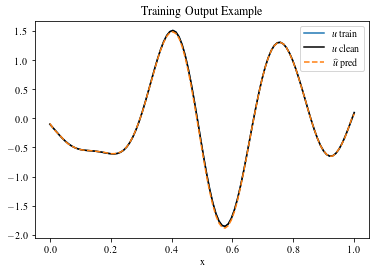

Epoch 290 Relative Error 0.019544295966625214
Epoch 291 Relative Error 0.01320659276098013
Epoch 292 Relative Error 0.009644325822591782
Epoch 293 Relative Error 0.016003983095288277
Epoch 294 Relative Error 0.01550788339227438
Epoch 295 Relative Error 0.00916069932281971
Epoch 296 Relative Error 0.011107761412858963
Epoch 297 Relative Error 0.014809631742537022
Epoch 298 Relative Error 0.011701950803399086
Epoch 299 Relative Error 0.00803019106388092


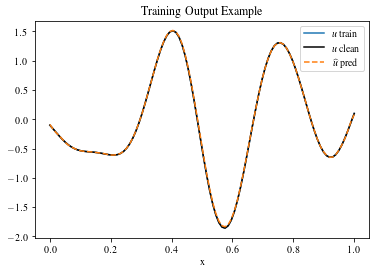

Epoch 300 Relative Error 0.011753283441066742
Epoch 301 Relative Error 0.012733424082398415
Epoch 302 Relative Error 0.009091229178011417
Epoch 303 Relative Error 0.008390524424612522
Epoch 304 Relative Error 0.011329567059874535
Epoch 305 Relative Error 0.01080439891666174
Epoch 306 Relative Error 0.007856433279812336
Epoch 307 Relative Error 0.008660269901156425
Epoch 308 Relative Error 0.01053680945187807
Epoch 309 Relative Error 0.009305529296398163


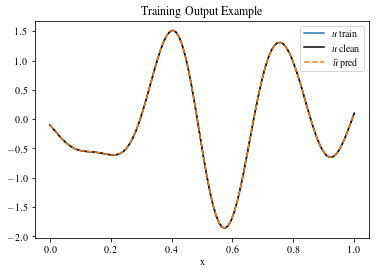

Epoch 310 Relative Error 0.0074971457943320274
Epoch 311 Relative Error 0.00868318136781454
Epoch 312 Relative Error 0.009598192758858204
Epoch 313 Relative Error 0.008407896384596825
Epoch 314 Relative Error 0.007461726199835539
Epoch 315 Relative Error 0.00844305194914341
Epoch 316 Relative Error 0.008863969705998898
Epoch 317 Relative Error 0.007878761738538742
Epoch 318 Relative Error 0.007461714092642069
Epoch 319 Relative Error 0.008159021846950054


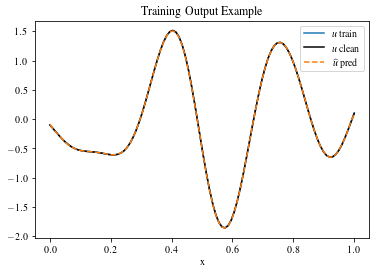

Epoch 320 Relative Error 0.00828796997666359
Epoch 321 Relative Error 0.007632108870893717
Epoch 322 Relative Error 0.007393416482955217
Epoch 323 Relative Error 0.00785616971552372
Epoch 324 Relative Error 0.007941043004393578
Epoch 325 Relative Error 0.007462041452527046
Epoch 326 Relative Error 0.007313464768230915
Epoch 327 Relative Error 0.007607833947986364
Epoch 328 Relative Error 0.007668571081012487
Epoch 329 Relative Error 0.007385851349681616


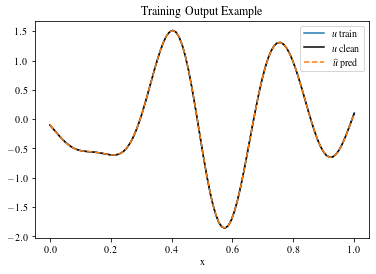

Epoch 330 Relative Error 0.007222778629511595
Epoch 331 Relative Error 0.007395607884973288
Epoch 332 Relative Error 0.007488652598112822
Epoch 333 Relative Error 0.007296503055840731
Epoch 334 Relative Error 0.007167248521000147
Epoch 335 Relative Error 0.007244851440191269
Epoch 336 Relative Error 0.007316501345485449
Epoch 337 Relative Error 0.007241824176162481
Epoch 338 Relative Error 0.007105324883013964
Epoch 339 Relative Error 0.007124758325517178


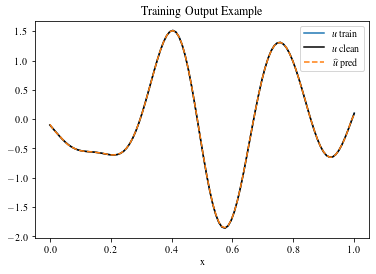

Epoch 340 Relative Error 0.007204985711723566
Epoch 341 Relative Error 0.007153322920203209
Epoch 342 Relative Error 0.007067112717777491
Epoch 343 Relative Error 0.007042239885777235
Epoch 344 Relative Error 0.007083002012223005
Epoch 345 Relative Error 0.0070971050299704075
Epoch 346 Relative Error 0.007017639931291342
Epoch 347 Relative Error 0.006977379787713289
Epoch 348 Relative Error 0.006999722681939602
Epoch 349 Relative Error 0.007008022163063288


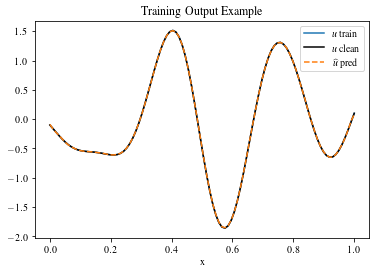

Epoch 350 Relative Error 0.006985063198953867
Epoch 351 Relative Error 0.006930238101631403
Epoch 352 Relative Error 0.006920944433659315
Epoch 353 Relative Error 0.006941268686205149
Epoch 354 Relative Error 0.0069235265254974365
Epoch 355 Relative Error 0.006894593592733145
Epoch 356 Relative Error 0.006868469063192606
Epoch 357 Relative Error 0.00686605554074049
Epoch 358 Relative Error 0.006871476303786039
Epoch 359 Relative Error 0.0068474640138447285


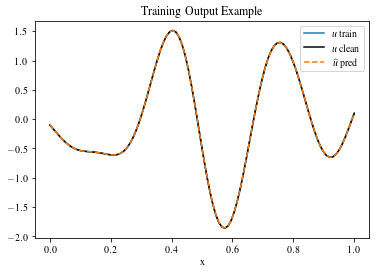

Epoch 360 Relative Error 0.006824191194027662
Epoch 361 Relative Error 0.006811920553445816
Epoch 362 Relative Error 0.006806592922657728
Epoch 363 Relative Error 0.0068020629696547985
Epoch 364 Relative Error 0.006782056298106909
Epoch 365 Relative Error 0.006764308549463749
Epoch 366 Relative Error 0.006754213944077492
Epoch 367 Relative Error 0.006745361723005772
Epoch 368 Relative Error 0.0067390091717243195
Epoch 369 Relative Error 0.006722001824527979


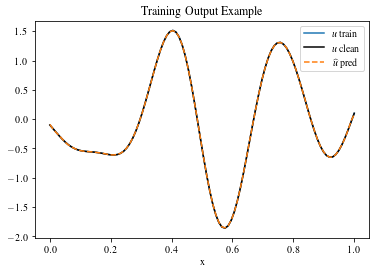

Epoch 370 Relative Error 0.006706839893013239
Epoch 371 Relative Error 0.006697408389300108
Epoch 372 Relative Error 0.006687511224299669
Epoch 373 Relative Error 0.006679454352706671
Epoch 374 Relative Error 0.006666042376309633
Epoch 375 Relative Error 0.006651782430708408
Epoch 376 Relative Error 0.006644715555012226
Epoch 377 Relative Error 0.006635335739701986
Epoch 378 Relative Error 0.006633560173213482
Epoch 379 Relative Error 0.0066264015622437


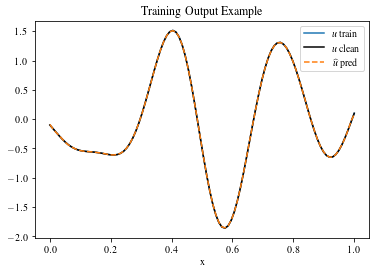

Epoch 380 Relative Error 0.006636138539761305
Epoch 381 Relative Error 0.006653962191194296
Epoch 382 Relative Error 0.0067212507128715515
Epoch 383 Relative Error 0.006837039720267057
Epoch 384 Relative Error 0.007114224135875702
Epoch 385 Relative Error 0.007611899171024561
Epoch 386 Relative Error 0.008634092286229134
Epoch 387 Relative Error 0.010391547344624996
Epoch 388 Relative Error 0.013479065150022507
Epoch 389 Relative Error 0.01834309659898281


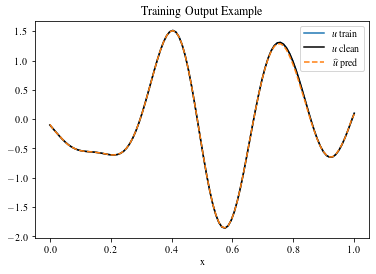

Epoch 390 Relative Error 0.026027550920844078
Epoch 391 Relative Error 0.03763018175959587
Epoch 392 Relative Error 0.05531346797943115
Epoch 393 Relative Error 0.0818999782204628
Epoch 394 Relative Error 0.12224431335926056
Epoch 395 Relative Error 0.17801493406295776
Epoch 396 Relative Error 0.2288111448287964
Epoch 397 Relative Error 0.226168692111969
Epoch 398 Relative Error 0.14656691253185272
Epoch 399 Relative Error 0.056466471403837204


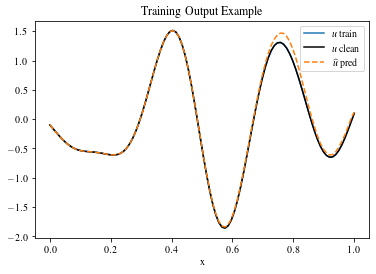

Epoch 400 Relative Error 0.11850064992904663
Epoch 401 Relative Error 0.16695387661457062
Epoch 402 Relative Error 0.14335210621356964
Epoch 403 Relative Error 0.06559634208679199
Epoch 404 Relative Error 0.07254265248775482
Epoch 405 Relative Error 0.13243624567985535
Epoch 406 Relative Error 0.11968300491571426
Epoch 407 Relative Error 0.04032808542251587
Epoch 408 Relative Error 0.0631866380572319
Epoch 409 Relative Error 0.11038421839475632


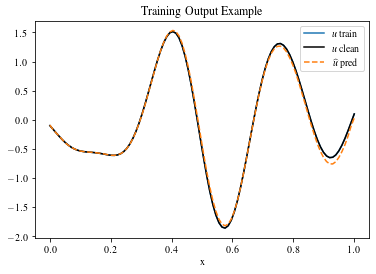

Epoch 410 Relative Error 0.08834826201200485
Epoch 411 Relative Error 0.03367573395371437
Epoch 412 Relative Error 0.06212776154279709
Epoch 413 Relative Error 0.086118683218956
Epoch 414 Relative Error 0.06837742775678635
Epoch 415 Relative Error 0.03611872345209122
Epoch 416 Relative Error 0.05208154022693634
Epoch 417 Relative Error 0.06954054534435272
Epoch 418 Relative Error 0.054565224796533585
Epoch 419 Relative Error 0.030179807916283607


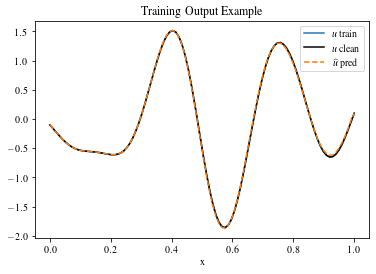

Epoch 420 Relative Error 0.047326136380434036
Epoch 421 Relative Error 0.05602242052555084
Epoch 422 Relative Error 0.03954998776316643
Epoch 423 Relative Error 0.031122643500566483
Epoch 424 Relative Error 0.042777977883815765
Epoch 425 Relative Error 0.04143036901950836
Epoch 426 Relative Error 0.031097905710339546
Epoch 427 Relative Error 0.03132417052984238
Epoch 428 Relative Error 0.03472266346216202
Epoch 429 Relative Error 0.03042328916490078


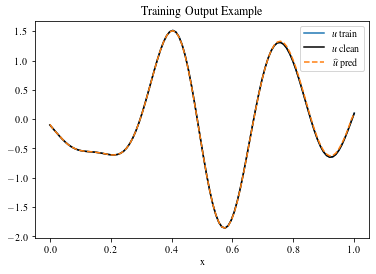

Epoch 430 Relative Error 0.02602587454020977
Epoch 431 Relative Error 0.028190620243549347
Epoch 432 Relative Error 0.02832496166229248
Epoch 433 Relative Error 0.022876210510730743
Epoch 434 Relative Error 0.020787877961993217
Epoch 435 Relative Error 0.024950159713625908
Epoch 436 Relative Error 0.02408609725534916
Epoch 437 Relative Error 0.016860229894518852
Epoch 438 Relative Error 0.016473814845085144
Epoch 439 Relative Error 0.021912777796387672


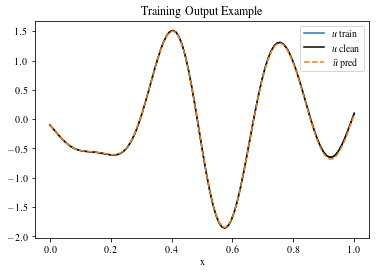

Epoch 440 Relative Error 0.02038406953215599
Epoch 441 Relative Error 0.01343602780252695
Epoch 442 Relative Error 0.013182389549911022
Epoch 443 Relative Error 0.018578937277197838
Epoch 444 Relative Error 0.018622981384396553
Epoch 445 Relative Error 0.01280130259692669
Epoch 446 Relative Error 0.012555330991744995
Epoch 447 Relative Error 0.018795229494571686
Epoch 448 Relative Error 0.021452171728014946
Epoch 449 Relative Error 0.022321129217743874


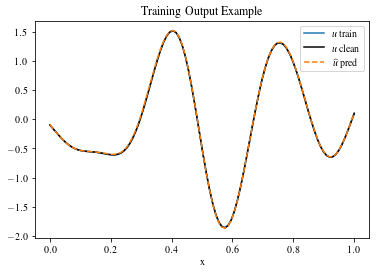

Epoch 450 Relative Error 0.028073780238628387
Epoch 451 Relative Error 0.038797035813331604
Epoch 452 Relative Error 0.05256827920675278
Epoch 453 Relative Error 0.07115017622709274
Epoch 454 Relative Error 0.09838688373565674
Epoch 455 Relative Error 0.1374969184398651
Epoch 456 Relative Error 0.19245873391628265
Epoch 457 Relative Error 0.26401087641716003
Epoch 458 Relative Error 0.33494818210601807
Epoch 459 Relative Error 0.35486525297164917


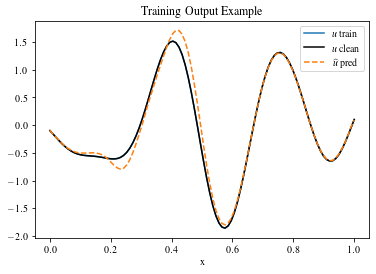

Epoch 460 Relative Error 0.2951676845550537
Epoch 461 Relative Error 0.2154715359210968
Epoch 462 Relative Error 0.17735150456428528
Epoch 463 Relative Error 0.19900691509246826
Epoch 464 Relative Error 0.2310996800661087
Epoch 465 Relative Error 0.2088841199874878
Epoch 466 Relative Error 0.14833196997642517
Epoch 467 Relative Error 0.13577900826931
Epoch 468 Relative Error 0.15775184333324432
Epoch 469 Relative Error 0.15639901161193848


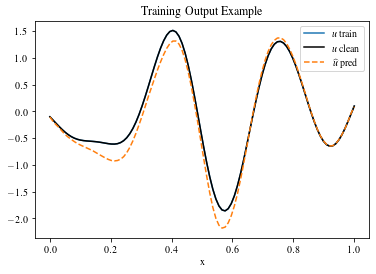

Epoch 470 Relative Error 0.12952278554439545
Epoch 471 Relative Error 0.10458508133888245
Epoch 472 Relative Error 0.12741270661354065
Epoch 473 Relative Error 0.13879501819610596
Epoch 474 Relative Error 0.10666696727275848
Epoch 475 Relative Error 0.09151481091976166
Epoch 476 Relative Error 0.10695993155241013
Epoch 477 Relative Error 0.10188362002372742
Epoch 478 Relative Error 0.08278918266296387
Epoch 479 Relative Error 0.07437510788440704


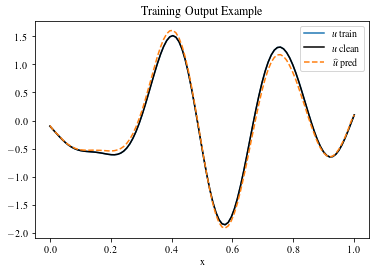

Epoch 480 Relative Error 0.08698593825101852
Epoch 481 Relative Error 0.09376450628042221
Epoch 482 Relative Error 0.0770849734544754
Epoch 483 Relative Error 0.058394283056259155
Epoch 484 Relative Error 0.06167200580239296
Epoch 485 Relative Error 0.06675109267234802
Epoch 486 Relative Error 0.06294694542884827
Epoch 487 Relative Error 0.05220372974872589
Epoch 488 Relative Error 0.04631396010518074
Epoch 489 Relative Error 0.05282052233815193


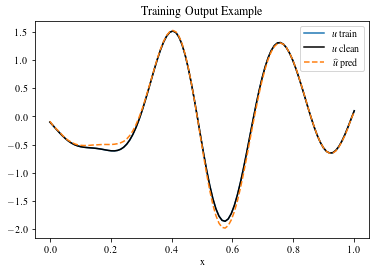

Epoch 490 Relative Error 0.057483453303575516
Epoch 491 Relative Error 0.05062434449791908
Epoch 492 Relative Error 0.0367419570684433
Epoch 493 Relative Error 0.036907296627759933
Epoch 494 Relative Error 0.045706842094659805
Epoch 495 Relative Error 0.0429990254342556
Epoch 496 Relative Error 0.030272861942648888
Epoch 497 Relative Error 0.02727479860186577
Epoch 498 Relative Error 0.03676454722881317
Epoch 499 Relative Error 0.03889434412121773


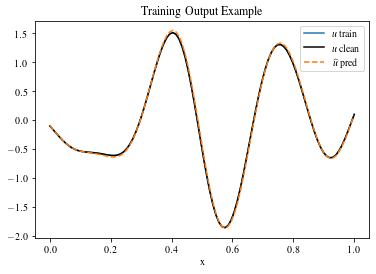

Epoch 500 Relative Error 0.030841240659356117
Epoch 501 Relative Error 0.02396874502301216
Epoch 502 Relative Error 0.028103183954954147
Epoch 503 Relative Error 0.029688812792301178
Epoch 504 Relative Error 0.023273896425962448
Epoch 505 Relative Error 0.018267840147018433
Epoch 506 Relative Error 0.02106829360127449
Epoch 507 Relative Error 0.02328815497457981
Epoch 508 Relative Error 0.02096475102007389
Epoch 509 Relative Error 0.016381775960326195


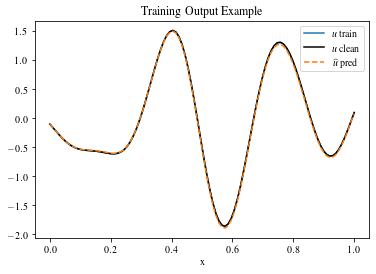

Epoch 510 Relative Error 0.016951588913798332
Epoch 511 Relative Error 0.020515907555818558
Epoch 512 Relative Error 0.01927267387509346
Epoch 513 Relative Error 0.015295798890292645
Epoch 514 Relative Error 0.014652825891971588
Epoch 515 Relative Error 0.015963910147547722
Epoch 516 Relative Error 0.01612401381134987
Epoch 517 Relative Error 0.014299098402261734
Epoch 518 Relative Error 0.010942354798316956
Epoch 519 Relative Error 0.010377749800682068


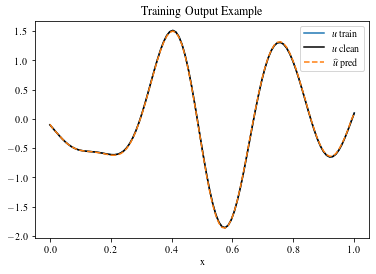

Epoch 520 Relative Error 0.012379150837659836
Epoch 521 Relative Error 0.012420290149748325
Epoch 522 Relative Error 0.011044164188206196
Epoch 523 Relative Error 0.010074811987578869
Epoch 524 Relative Error 0.009292439557611942
Epoch 525 Relative Error 0.009838147088885307
Epoch 526 Relative Error 0.011090219020843506
Epoch 527 Relative Error 0.010624152608215809
Epoch 528 Relative Error 0.009144965559244156
Epoch 529 Relative Error 0.008403831161558628


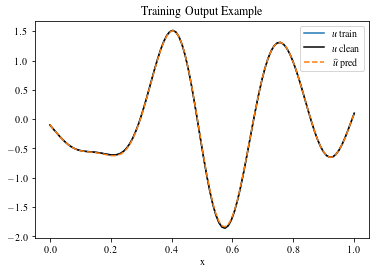

Epoch 530 Relative Error 0.009175939485430717
Epoch 531 Relative Error 0.010190940462052822
Epoch 532 Relative Error 0.009840678423643112
Epoch 533 Relative Error 0.00840328261256218
Epoch 534 Relative Error 0.008450927212834358
Epoch 535 Relative Error 0.009454939514398575
Epoch 536 Relative Error 0.009553840383887291
Epoch 537 Relative Error 0.008886024355888367
Epoch 538 Relative Error 0.008792968466877937
Epoch 539 Relative Error 0.009214202873408794


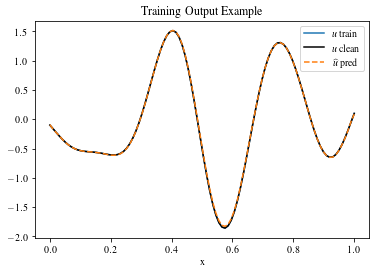

Epoch 540 Relative Error 0.009724201634526253
Epoch 541 Relative Error 0.010040011256933212
Epoch 542 Relative Error 0.01070651225745678
Epoch 543 Relative Error 0.011660727672278881
Epoch 544 Relative Error 0.012906301766633987
Epoch 545 Relative Error 0.014207735657691956
Epoch 546 Relative Error 0.01584688201546669
Epoch 547 Relative Error 0.01776067167520523
Epoch 548 Relative Error 0.020295962691307068
Epoch 549 Relative Error 0.023422036319971085


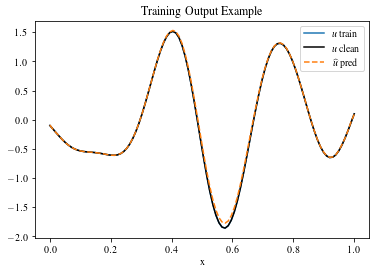

Epoch 550 Relative Error 0.02755582518875599
Epoch 551 Relative Error 0.0326240137219429
Epoch 552 Relative Error 0.03907810151576996
Epoch 553 Relative Error 0.047049909830093384
Epoch 554 Relative Error 0.05713933706283569
Epoch 555 Relative Error 0.06945524364709854
Epoch 556 Relative Error 0.08410912752151489
Epoch 557 Relative Error 0.09986252337694168
Epoch 558 Relative Error 0.1145680621266365
Epoch 559 Relative Error 0.12416991591453552


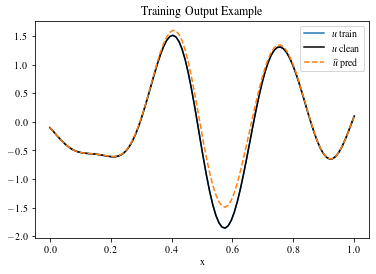

Epoch 560 Relative Error 0.1245320588350296
Epoch 561 Relative Error 0.11262228339910507
Epoch 562 Relative Error 0.08972204476594925
Epoch 563 Relative Error 0.061805639415979385
Epoch 564 Relative Error 0.04111446812748909
Epoch 565 Relative Error 0.04113439470529556
Epoch 566 Relative Error 0.052119117230176926
Epoch 567 Relative Error 0.0612417533993721
Epoch 568 Relative Error 0.06584285944700241
Epoch 569 Relative Error 0.06686963140964508


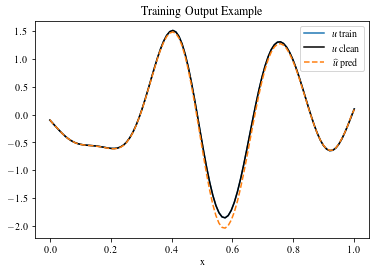

Epoch 570 Relative Error 0.06445115804672241
Epoch 571 Relative Error 0.05766834318637848
Epoch 572 Relative Error 0.04600096866488457
Epoch 573 Relative Error 0.0311884768307209
Epoch 574 Relative Error 0.021089347079396248
Epoch 575 Relative Error 0.02668418176472187
Epoch 576 Relative Error 0.03842068463563919
Epoch 577 Relative Error 0.04647776857018471
Epoch 578 Relative Error 0.048113614320755005
Epoch 579 Relative Error 0.04356099292635918


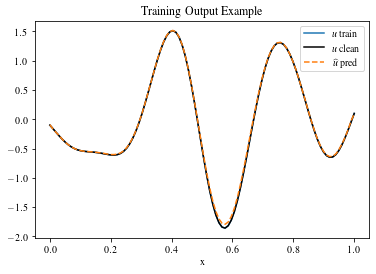

Epoch 580 Relative Error 0.034662555903196335
Epoch 581 Relative Error 0.024628611281514168
Epoch 582 Relative Error 0.017945030704140663
Epoch 583 Relative Error 0.01791677251458168
Epoch 584 Relative Error 0.02173663303256035
Epoch 585 Relative Error 0.025457749143242836
Epoch 586 Relative Error 0.02799464948475361
Epoch 587 Relative Error 0.029247455298900604
Epoch 588 Relative Error 0.028921129181981087
Epoch 589 Relative Error 0.02686772681772709


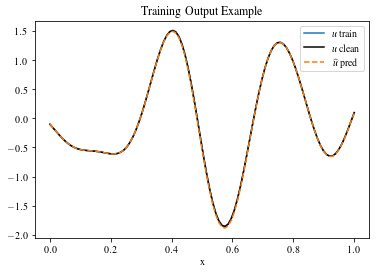

Epoch 590 Relative Error 0.022892992943525314
Epoch 591 Relative Error 0.017552096396684647
Epoch 592 Relative Error 0.01206116285175085
Epoch 593 Relative Error 0.009313121438026428
Epoch 594 Relative Error 0.011531313881278038
Epoch 595 Relative Error 0.015152637846767902
Epoch 596 Relative Error 0.017988305538892746
Epoch 597 Relative Error 0.01923324167728424
Epoch 598 Relative Error 0.019210301339626312
Epoch 599 Relative Error 0.018201489001512527


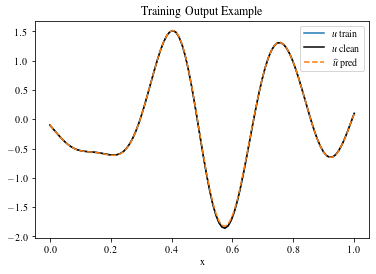

Epoch 600 Relative Error 0.016603734344244003
Epoch 601 Relative Error 0.014651577919721603
Epoch 602 Relative Error 0.012294473126530647
Epoch 603 Relative Error 0.009840689599514008
Epoch 604 Relative Error 0.00740368478000164
Epoch 605 Relative Error 0.006311474367976189
Epoch 606 Relative Error 0.007107787299901247
Epoch 607 Relative Error 0.009013980627059937
Epoch 608 Relative Error 0.010883565992116928
Epoch 609 Relative Error 0.012041407637298107


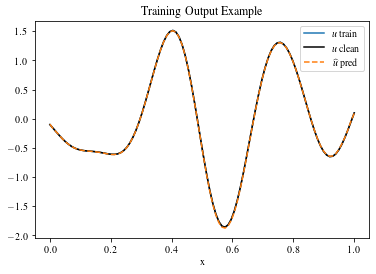

Epoch 610 Relative Error 0.012507730163633823
Epoch 611 Relative Error 0.012207377701997757
Epoch 612 Relative Error 0.011492917314171791
Epoch 613 Relative Error 0.010522621683776379
Epoch 614 Relative Error 0.009546123445034027
Epoch 615 Relative Error 0.008682606741786003
Epoch 616 Relative Error 0.007822749204933643
Epoch 617 Relative Error 0.007040037307888269
Epoch 618 Relative Error 0.0061803883872926235
Epoch 619 Relative Error 0.005550672300159931


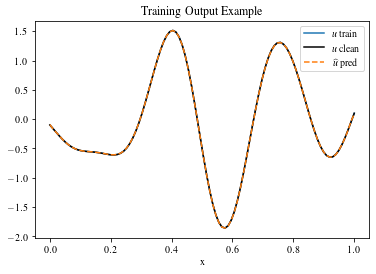

Epoch 620 Relative Error 0.005158220883458853
Epoch 621 Relative Error 0.0052451035007834435
Epoch 622 Relative Error 0.005607765633612871
Epoch 623 Relative Error 0.006073415745049715
Epoch 624 Relative Error 0.006515126209706068
Epoch 625 Relative Error 0.006788796745240688
Epoch 626 Relative Error 0.006988030392676592
Epoch 627 Relative Error 0.007059129886329174
Epoch 628 Relative Error 0.007147611118853092
Epoch 629 Relative Error 0.0072303940542042255


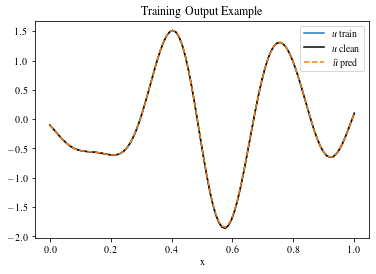

Epoch 630 Relative Error 0.007352763321250677
Epoch 631 Relative Error 0.007489729672670364
Epoch 632 Relative Error 0.007612362504005432
Epoch 633 Relative Error 0.007723779417574406
Epoch 634 Relative Error 0.007821906358003616
Epoch 635 Relative Error 0.007925844751298428
Epoch 636 Relative Error 0.008075748570263386
Epoch 637 Relative Error 0.008261092938482761
Epoch 638 Relative Error 0.008546022698283195
Epoch 639 Relative Error 0.00887028407305479


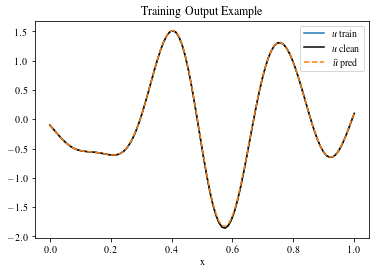

Epoch 640 Relative Error 0.009320777840912342
Epoch 641 Relative Error 0.009826344437897205
Epoch 642 Relative Error 0.01049791555851698
Epoch 643 Relative Error 0.01127183623611927
Epoch 644 Relative Error 0.01227322407066822
Epoch 645 Relative Error 0.013450158759951591
Epoch 646 Relative Error 0.014931462705135345
Epoch 647 Relative Error 0.016689719632267952
Epoch 648 Relative Error 0.018859921023249626
Epoch 649 Relative Error 0.021451368927955627


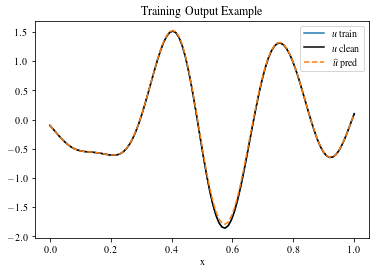

Epoch 650 Relative Error 0.024627018719911575
Epoch 651 Relative Error 0.028444210067391396
Epoch 652 Relative Error 0.03311830386519432
Epoch 653 Relative Error 0.03877333179116249
Epoch 654 Relative Error 0.04571153223514557
Epoch 655 Relative Error 0.05416435748338699
Epoch 656 Relative Error 0.0645744726061821
Epoch 657 Relative Error 0.0773429200053215
Epoch 658 Relative Error 0.0930975005030632
Epoch 659 Relative Error 0.1123734712600708


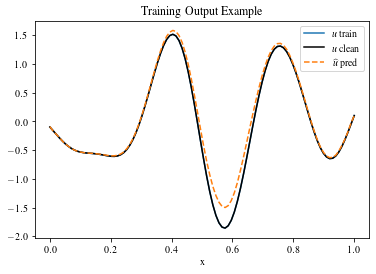

Epoch 660 Relative Error 0.1356775313615799
Epoch 661 Relative Error 0.16273996233940125
Epoch 662 Relative Error 0.19202817976474762
Epoch 663 Relative Error 0.21955926716327667
Epoch 664 Relative Error 0.23908348381519318
Epoch 665 Relative Error 0.2441108524799347
Epoch 666 Relative Error 0.2335243672132492
Epoch 667 Relative Error 0.21553893387317657
Epoch 668 Relative Error 0.2046266347169876
Epoch 669 Relative Error 0.20734229683876038


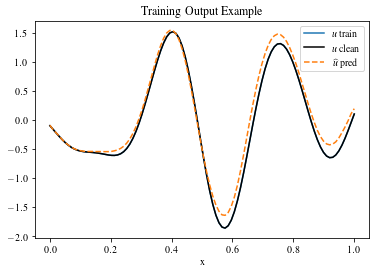

Epoch 670 Relative Error 0.21608233451843262
Epoch 671 Relative Error 0.2180502563714981
Epoch 672 Relative Error 0.2036363184452057
Epoch 673 Relative Error 0.16818727552890778
Epoch 674 Relative Error 0.11754894256591797
Epoch 675 Relative Error 0.07594400644302368
Epoch 676 Relative Error 0.0839243084192276
Epoch 677 Relative Error 0.116108238697052
Epoch 678 Relative Error 0.13519905507564545
Epoch 679 Relative Error 0.13361410796642303


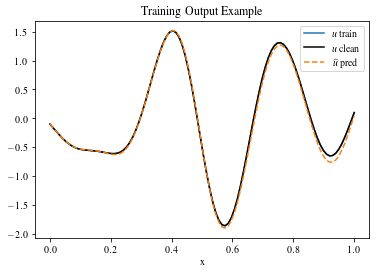

Epoch 680 Relative Error 0.11664562672376633
Epoch 681 Relative Error 0.09788255393505096
Epoch 682 Relative Error 0.09110936522483826
Epoch 683 Relative Error 0.09478699415922165
Epoch 684 Relative Error 0.09543456882238388
Epoch 685 Relative Error 0.0854467824101448
Epoch 686 Relative Error 0.06862588226795197
Epoch 687 Relative Error 0.059099845588207245
Epoch 688 Relative Error 0.06546912342309952
Epoch 689 Relative Error 0.07485983520746231


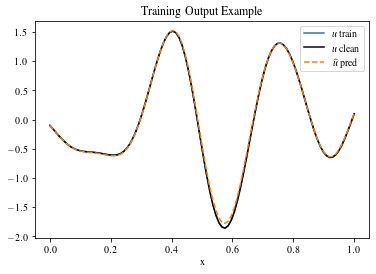

Epoch 690 Relative Error 0.07495391368865967
Epoch 691 Relative Error 0.06279189139604568
Epoch 692 Relative Error 0.04307417944073677
Epoch 693 Relative Error 0.029626984149217606
Epoch 694 Relative Error 0.038283757865428925
Epoch 695 Relative Error 0.05306876450777054
Epoch 696 Relative Error 0.061305612325668335
Epoch 697 Relative Error 0.06080855056643486
Epoch 698 Relative Error 0.053159452974796295
Epoch 699 Relative Error 0.04250520095229149


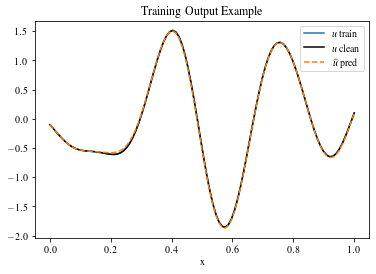

Epoch 700 Relative Error 0.03428318724036217
Epoch 701 Relative Error 0.03324655070900917
Epoch 702 Relative Error 0.036614786833524704
Epoch 703 Relative Error 0.038762036710977554
Epoch 704 Relative Error 0.037261031568050385
Epoch 705 Relative Error 0.03249535709619522
Epoch 706 Relative Error 0.027360858395695686
Epoch 707 Relative Error 0.024792512878775597
Epoch 708 Relative Error 0.02555864304304123
Epoch 709 Relative Error 0.026752304285764694


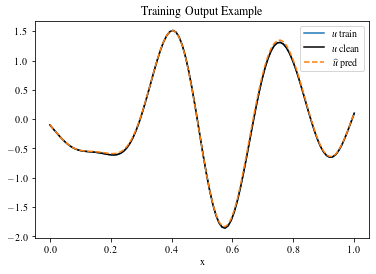

Epoch 710 Relative Error 0.02571984939277172
Epoch 711 Relative Error 0.02208155021071434
Epoch 712 Relative Error 0.017055295407772064
Epoch 713 Relative Error 0.014185943640768528
Epoch 714 Relative Error 0.015540046617388725
Epoch 715 Relative Error 0.018178245052695274
Epoch 716 Relative Error 0.01908283866941929
Epoch 717 Relative Error 0.01731818914413452
Epoch 718 Relative Error 0.013925015926361084
Epoch 719 Relative Error 0.011075153015553951


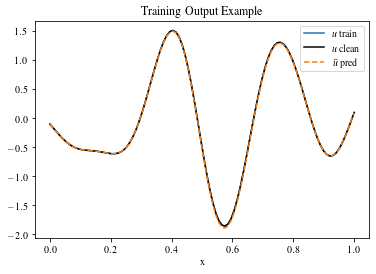

Epoch 720 Relative Error 0.011377002112567425
Epoch 721 Relative Error 0.013811002485454082
Epoch 722 Relative Error 0.01564847305417061
Epoch 723 Relative Error 0.015960073098540306
Epoch 724 Relative Error 0.014594713225960732
Epoch 725 Relative Error 0.012516731396317482
Epoch 726 Relative Error 0.011041008867323399
Epoch 727 Relative Error 0.011242876760661602
Epoch 728 Relative Error 0.012857059948146343
Epoch 729 Relative Error 0.014775581657886505


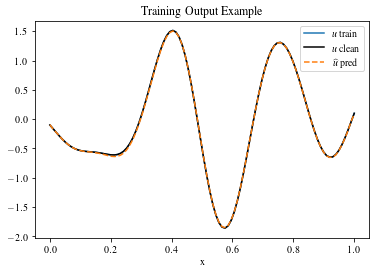

Epoch 730 Relative Error 0.016628509387373924
Epoch 731 Relative Error 0.01828666403889656
Epoch 732 Relative Error 0.020130755379796028
Epoch 733 Relative Error 0.022429412230849266
Epoch 734 Relative Error 0.02542451024055481
Epoch 735 Relative Error 0.029262807220220566
Epoch 736 Relative Error 0.034019649028778076
Epoch 737 Relative Error 0.03979840502142906
Epoch 738 Relative Error 0.046819884330034256
Epoch 739 Relative Error 0.05539373680949211


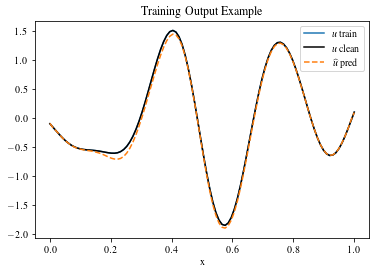

Epoch 740 Relative Error 0.06595529615879059
Epoch 741 Relative Error 0.07894592732191086
Epoch 742 Relative Error 0.09496438503265381
Epoch 743 Relative Error 0.11468756943941116
Epoch 744 Relative Error 0.13906340301036835
Epoch 745 Relative Error 0.16917243599891663
Epoch 746 Relative Error 0.20605216920375824
Epoch 747 Relative Error 0.249874085187912
Epoch 748 Relative Error 0.2985342741012573
Epoch 749 Relative Error 0.34533533453941345


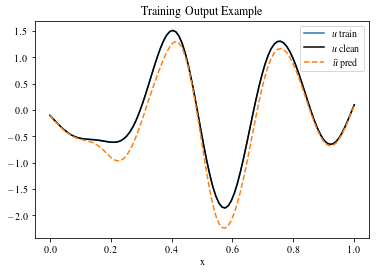

Epoch 750 Relative Error 0.3788340091705322
Epoch 751 Relative Error 0.386233389377594
Epoch 752 Relative Error 0.36021408438682556
Epoch 753 Relative Error 0.3044095039367676
Epoch 754 Relative Error 0.238546222448349
Epoch 755 Relative Error 0.20518049597740173
Epoch 756 Relative Error 0.2247726321220398
Epoch 757 Relative Error 0.24992206692695618
Epoch 758 Relative Error 0.23829995095729828
Epoch 759 Relative Error 0.18959687650203705


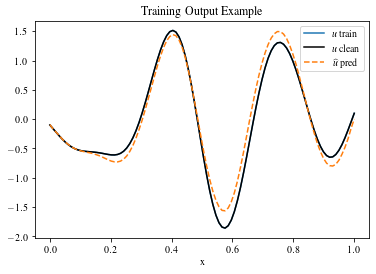

Epoch 760 Relative Error 0.15285629034042358
Epoch 761 Relative Error 0.1752384454011917
Epoch 762 Relative Error 0.20372949540615082
Epoch 763 Relative Error 0.18949511647224426
Epoch 764 Relative Error 0.13206256926059723
Epoch 765 Relative Error 0.07891054451465607
Epoch 766 Relative Error 0.10545365512371063
Epoch 767 Relative Error 0.14368700981140137
Epoch 768 Relative Error 0.14571502804756165
Epoch 769 Relative Error 0.11786951124668121


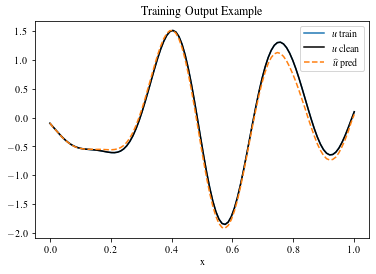

Epoch 770 Relative Error 0.09343170374631882
Epoch 771 Relative Error 0.0983833447098732
Epoch 772 Relative Error 0.10969379544258118
Epoch 773 Relative Error 0.10575935989618301
Epoch 774 Relative Error 0.08935301005840302
Epoch 775 Relative Error 0.07621301710605621
Epoch 776 Relative Error 0.07620709389448166
Epoch 777 Relative Error 0.08035726100206375
Epoch 778 Relative Error 0.07885252684354782
Epoch 779 Relative Error 0.07127153128385544


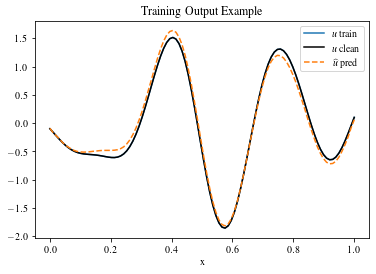

Epoch 780 Relative Error 0.061729125678539276
Epoch 781 Relative Error 0.05452263355255127
Epoch 782 Relative Error 0.05122171714901924
Epoch 783 Relative Error 0.051531337201595306
Epoch 784 Relative Error 0.05508147552609444
Epoch 785 Relative Error 0.05852896347641945
Epoch 786 Relative Error 0.057440098375082016
Epoch 787 Relative Error 0.04965166375041008
Epoch 788 Relative Error 0.03739003464579582
Epoch 789 Relative Error 0.03059292398393154


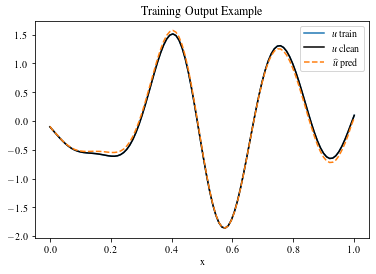

Epoch 790 Relative Error 0.03582274913787842
Epoch 791 Relative Error 0.04265725985169411
Epoch 792 Relative Error 0.04262850806117058
Epoch 793 Relative Error 0.03477776050567627
Epoch 794 Relative Error 0.024790382012724876
Epoch 795 Relative Error 0.022781984880566597
Epoch 796 Relative Error 0.028015369549393654
Epoch 797 Relative Error 0.03033403865993023
Epoch 798 Relative Error 0.026494815945625305
Epoch 799 Relative Error 0.020534848794341087


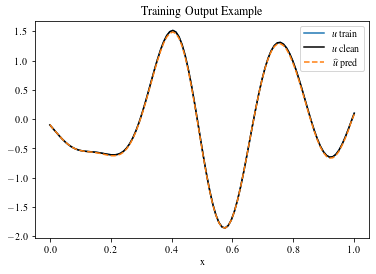

Epoch 800 Relative Error 0.019217180088162422
Epoch 801 Relative Error 0.022786276414990425
Epoch 802 Relative Error 0.02515506185591221
Epoch 803 Relative Error 0.02332540974020958
Epoch 804 Relative Error 0.019559115171432495
Epoch 805 Relative Error 0.01774255931377411
Epoch 806 Relative Error 0.018775394186377525
Epoch 807 Relative Error 0.01936381123960018
Epoch 808 Relative Error 0.017702236771583557
Epoch 809 Relative Error 0.01580793224275112


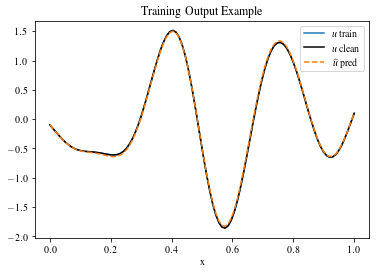

Epoch 810 Relative Error 0.016143057495355606
Epoch 811 Relative Error 0.01780053600668907
Epoch 812 Relative Error 0.018040606752038002
Epoch 813 Relative Error 0.015860212966799736
Epoch 814 Relative Error 0.013211142271757126
Epoch 815 Relative Error 0.012852031737565994
Epoch 816 Relative Error 0.014794516377151012
Epoch 817 Relative Error 0.016443228349089622
Epoch 818 Relative Error 0.016503017395734787
Epoch 819 Relative Error 0.015657857060432434


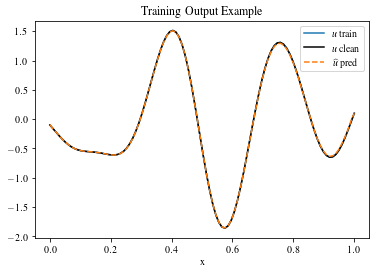

Epoch 820 Relative Error 0.015284907072782516
Epoch 821 Relative Error 0.015958737581968307
Epoch 822 Relative Error 0.017269235104322433
Epoch 823 Relative Error 0.018121033906936646
Epoch 824 Relative Error 0.018619120121002197
Epoch 825 Relative Error 0.019148601219058037
Epoch 826 Relative Error 0.020421750843524933
Epoch 827 Relative Error 0.02250014990568161
Epoch 828 Relative Error 0.02507638745009899
Epoch 829 Relative Error 0.02785607799887657


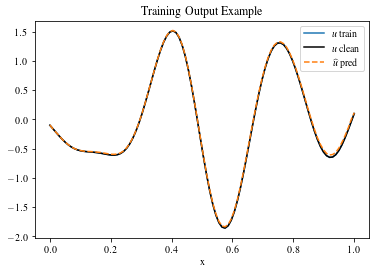

Epoch 830 Relative Error 0.03092346154153347
Epoch 831 Relative Error 0.03457744047045708
Epoch 832 Relative Error 0.039110153913497925
Epoch 833 Relative Error 0.04450521618127823
Epoch 834 Relative Error 0.05086687207221985
Epoch 835 Relative Error 0.05822935700416565
Epoch 836 Relative Error 0.06699768453836441
Epoch 837 Relative Error 0.0774395689368248
Epoch 838 Relative Error 0.09000144153833389
Epoch 839 Relative Error 0.10500273108482361


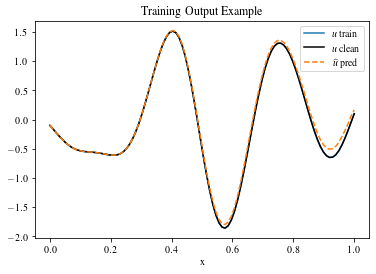

Epoch 840 Relative Error 0.12301009148359299
Epoch 841 Relative Error 0.14395642280578613
Epoch 842 Relative Error 0.1666315793991089
Epoch 843 Relative Error 0.18815936148166656
Epoch 844 Relative Error 0.20444345474243164
Epoch 845 Relative Error 0.21071156859397888
Epoch 846 Relative Error 0.20368795096874237
Epoch 847 Relative Error 0.1841427981853485
Epoch 848 Relative Error 0.15862184762954712
Epoch 849 Relative Error 0.1381271630525589


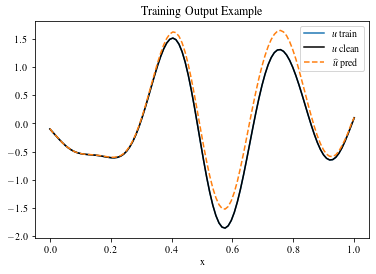

Epoch 850 Relative Error 0.13086813688278198
Epoch 851 Relative Error 0.13431759178638458
Epoch 852 Relative Error 0.1386401653289795
Epoch 853 Relative Error 0.13635507225990295
Epoch 854 Relative Error 0.12486661970615387
Epoch 855 Relative Error 0.10568755120038986
Epoch 856 Relative Error 0.08436751365661621
Epoch 857 Relative Error 0.06943061202764511
Epoch 858 Relative Error 0.06780055165290833
Epoch 859 Relative Error 0.07486756891012192


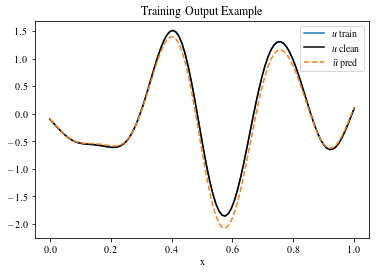

Epoch 860 Relative Error 0.08158840239048004
Epoch 861 Relative Error 0.08309361338615417
Epoch 862 Relative Error 0.07851509004831314
Epoch 863 Relative Error 0.06934407353401184
Epoch 864 Relative Error 0.05858950689435005
Epoch 865 Relative Error 0.050352972000837326
Epoch 866 Relative Error 0.04821997135877609
Epoch 867 Relative Error 0.05164925009012222
Epoch 868 Relative Error 0.05665932223200798
Epoch 869 Relative Error 0.059682175517082214


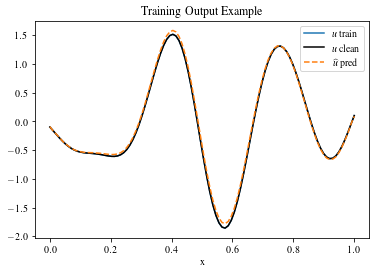

Epoch 870 Relative Error 0.059166282415390015
Epoch 871 Relative Error 0.05540885403752327
Epoch 872 Relative Error 0.04975883290171623
Epoch 873 Relative Error 0.044197533279657364
Epoch 874 Relative Error 0.04010439291596413
Epoch 875 Relative Error 0.037872374057769775
Epoch 876 Relative Error 0.036457985639572144
Epoch 877 Relative Error 0.03487062454223633
Epoch 878 Relative Error 0.03234950825572014
Epoch 879 Relative Error 0.029152637347579002


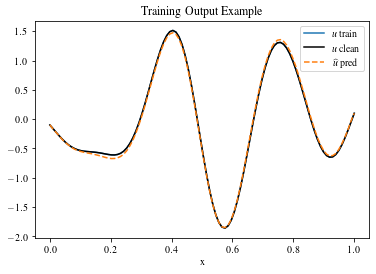

Epoch 880 Relative Error 0.02587122842669487
Epoch 881 Relative Error 0.023408537730574608
Epoch 882 Relative Error 0.022337637841701508
Epoch 883 Relative Error 0.022538185119628906
Epoch 884 Relative Error 0.023517213761806488
Epoch 885 Relative Error 0.024601895362138748
Epoch 886 Relative Error 0.025603782385587692
Epoch 887 Relative Error 0.02631240151822567
Epoch 888 Relative Error 0.02680894359946251
Epoch 889 Relative Error 0.026850750669836998


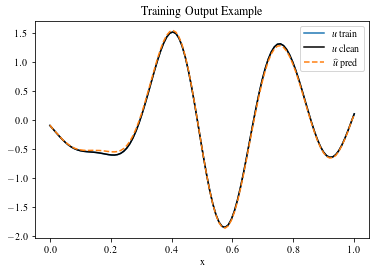

Epoch 890 Relative Error 0.026409883052110672
Epoch 891 Relative Error 0.025311976671218872
Epoch 892 Relative Error 0.023751044645905495
Epoch 893 Relative Error 0.02192634530365467
Epoch 894 Relative Error 0.020322205498814583
Epoch 895 Relative Error 0.01913359947502613
Epoch 896 Relative Error 0.018530504778027534
Epoch 897 Relative Error 0.01815733127295971
Epoch 898 Relative Error 0.017756765708327293
Epoch 899 Relative Error 0.016919735819101334


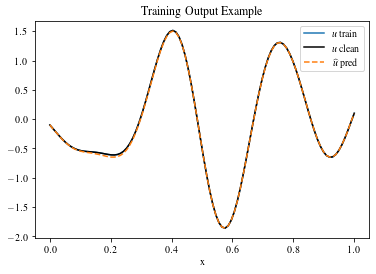

Epoch 900 Relative Error 0.01563417539000511
Epoch 901 Relative Error 0.013900193385779858
Epoch 902 Relative Error 0.012140383943915367
Epoch 903 Relative Error 0.010707436129450798
Epoch 904 Relative Error 0.010166161693632603
Epoch 905 Relative Error 0.010414442978799343
Epoch 906 Relative Error 0.011153213679790497
Epoch 907 Relative Error 0.011830165050923824
Epoch 908 Relative Error 0.012216612696647644
Epoch 909 Relative Error 0.012247161939740181


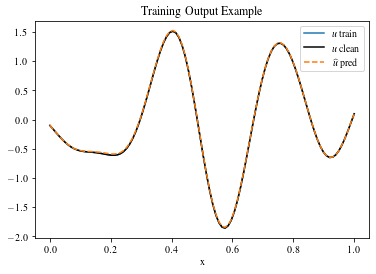

Epoch 910 Relative Error 0.012076164595782757
Epoch 911 Relative Error 0.011937425471842289
Epoch 912 Relative Error 0.01208475697785616
Epoch 913 Relative Error 0.01263586524873972
Epoch 914 Relative Error 0.013619991019368172
Epoch 915 Relative Error 0.014889911748468876
Epoch 916 Relative Error 0.016393935307860374
Epoch 917 Relative Error 0.018021252006292343
Epoch 918 Relative Error 0.019839497283101082
Epoch 919 Relative Error 0.021868854761123657


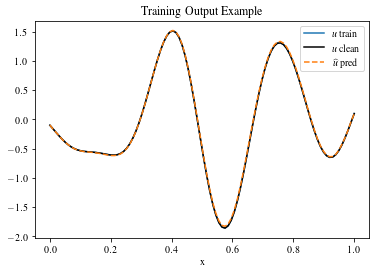

Epoch 920 Relative Error 0.024262424558401108
Epoch 921 Relative Error 0.027069231495261192
Epoch 922 Relative Error 0.030434567481279373
Epoch 923 Relative Error 0.03439854085445404
Epoch 924 Relative Error 0.03911115974187851
Epoch 925 Relative Error 0.044647857546806335
Epoch 926 Relative Error 0.05121101811528206
Epoch 927 Relative Error 0.05894232168793678
Epoch 928 Relative Error 0.06813084334135056
Epoch 929 Relative Error 0.07901261746883392


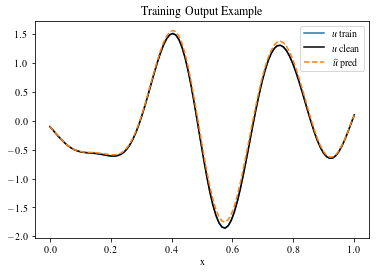

Epoch 930 Relative Error 0.09199171513319016
Epoch 931 Relative Error 0.10734053701162338
Epoch 932 Relative Error 0.1252652108669281
Epoch 933 Relative Error 0.14540418982505798
Epoch 934 Relative Error 0.166743203997612
Epoch 935 Relative Error 0.18703386187553406
Epoch 936 Relative Error 0.2031409740447998
Epoch 937 Relative Error 0.21115872263908386
Epoch 938 Relative Error 0.20817919075489044
Epoch 939 Relative Error 0.19394451379776


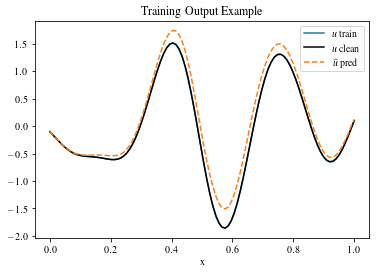

Epoch 940 Relative Error 0.17416617274284363
Epoch 941 Relative Error 0.16132423281669617
Epoch 942 Relative Error 0.16960516571998596
Epoch 943 Relative Error 0.2000800520181656
Epoch 944 Relative Error 0.24085454642772675
Epoch 945 Relative Error 0.27916935086250305
Epoch 946 Relative Error 0.3044535517692566
Epoch 947 Relative Error 0.30865180492401123
Epoch 948 Relative Error 0.2869700491428375
Epoch 949 Relative Error 0.243504136800766


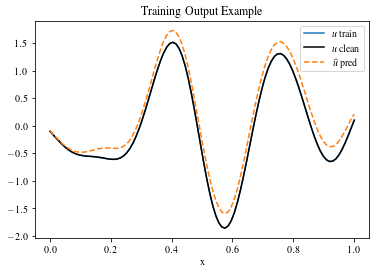

Epoch 950 Relative Error 0.19432741403579712
Epoch 951 Relative Error 0.164223313331604
Epoch 952 Relative Error 0.16358934342861176
Epoch 953 Relative Error 0.17217229306697845
Epoch 954 Relative Error 0.16886211931705475
Epoch 955 Relative Error 0.1496874988079071
Epoch 956 Relative Error 0.12747012078762054
Epoch 957 Relative Error 0.12082802504301071
Epoch 958 Relative Error 0.13059885799884796
Epoch 959 Relative Error 0.13854660093784332


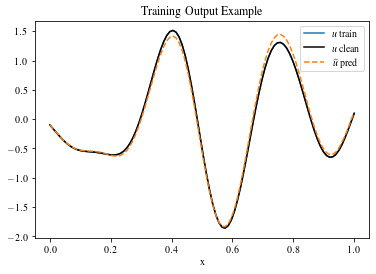

Epoch 960 Relative Error 0.13172078132629395
Epoch 961 Relative Error 0.1112699955701828
Epoch 962 Relative Error 0.08940714597702026
Epoch 963 Relative Error 0.0837574228644371
Epoch 964 Relative Error 0.09499047696590424
Epoch 965 Relative Error 0.10666612535715103
Epoch 966 Relative Error 0.10873610526323318
Epoch 967 Relative Error 0.0997096598148346
Epoch 968 Relative Error 0.08400262147188187
Epoch 969 Relative Error 0.06868242472410202


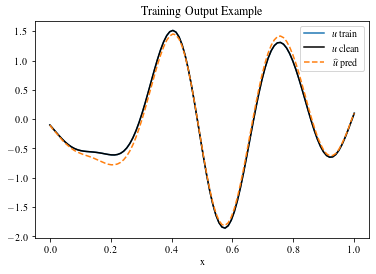

Epoch 970 Relative Error 0.061538681387901306
Epoch 971 Relative Error 0.06341845542192459
Epoch 972 Relative Error 0.06745433062314987
Epoch 973 Relative Error 0.06782163679599762
Epoch 974 Relative Error 0.0625453069806099
Epoch 975 Relative Error 0.0534079372882843
Epoch 976 Relative Error 0.044010307639837265
Epoch 977 Relative Error 0.039073433727025986
Epoch 978 Relative Error 0.03960114344954491
Epoch 979 Relative Error 0.041123729199171066


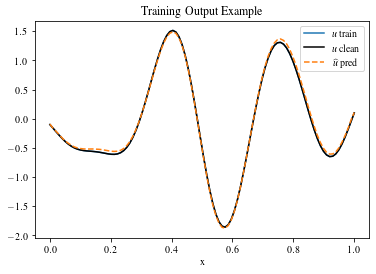

Epoch 980 Relative Error 0.04010803997516632
Epoch 981 Relative Error 0.0362936295568943
Epoch 982 Relative Error 0.03287988901138306
Epoch 983 Relative Error 0.03237254172563553
Epoch 984 Relative Error 0.03358517959713936
Epoch 985 Relative Error 0.0337897390127182
Epoch 986 Relative Error 0.03191100060939789
Epoch 987 Relative Error 0.02954907901585102
Epoch 988 Relative Error 0.028417766094207764
Epoch 989 Relative Error 0.028732702136039734


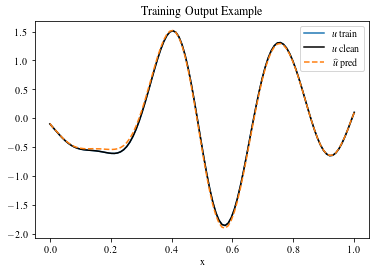

Epoch 990 Relative Error 0.029086580500006676
Epoch 991 Relative Error 0.02836107462644577
Epoch 992 Relative Error 0.027013732120394707
Epoch 993 Relative Error 0.02624327316880226
Epoch 994 Relative Error 0.02677774615585804
Epoch 995 Relative Error 0.028085947036743164
Epoch 996 Relative Error 0.02878967672586441
Epoch 997 Relative Error 0.028398720547556877
Epoch 998 Relative Error 0.027137327939271927
Epoch 999 Relative Error 0.026335543021559715


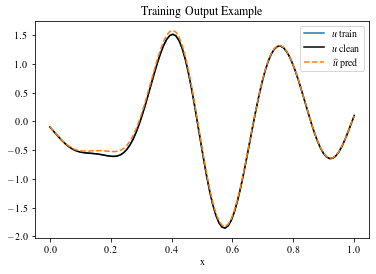

Epoch 1000 Relative Error 0.027071675285696983


In [64]:
greens_function, bias_term, _, _, res, G_res, beta_res, G_norms, beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, kernel, kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, beta_true=beta_true,
                   greens_lmbda=lmbda, bias_lmbda=lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=learning_rate, bias_learning_rate=learning_rate,
                   greens_weight_parametrizations=greens_weight_parametrizations, bias_weight_parametrizations=bias_weight_parametrizations,
                   greens_transform_output=greens_transform_output, bias_transform_output=bias_transform_output,
                   plotting_function=plotting_function, plotting_freq=plotting_freq, verbal=True)

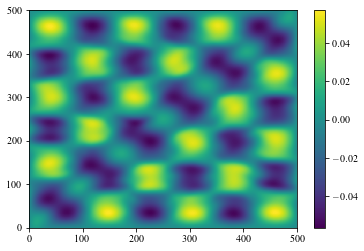

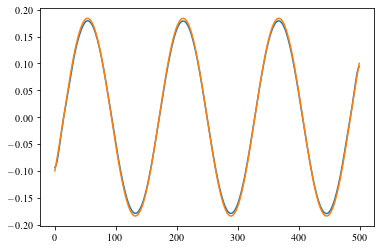

In [65]:
greens_function.update_mesh(greens_out_meshes_true)
G = greens_function().reshape(mx_true, mx_true)
plt.pcolormesh(G.cpu().detach())
plt.colorbar()
plt.show()

bias_term.update_mesh(bias_out_meshes_true)
beta = bias_term()
plt.plot(beta.cpu().detach())
plt.plot(beta_true.cpu().detach())
plt.show()

In [7]:
greens_weight_parametrizations = [] #[Symmetric((mx_weight, mx_weight), 0, 1)]

# Vary amount of noise
sigmas = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
lmbdas = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]

trials = 10

sigma_lmbda_res = np.zeros((len(sigmas), len(lmbdas), trials))
sigma_lmbda_G_res = np.zeros((len(sigmas), len(lmbdas), trials))
sigma_lmbda_beta_res = np.zeros((len(sigmas), len(lmbdas), trials))

sigma_lmbda_greens_functions = np.empty((len(sigmas), len(lmbdas), trials), dtype=object)
sigma_lmbda_bias_terms = np.empty((len(sigmas), len(lmbdas), trials), dtype=object)

if os.path.isfile("helmholtz_vs_sigma_lmbda/hemlholtz_vs_sigma_lmbda_res.npz"):
    results = np.load("helmholtz_vs_sigma_lmbda/hemlholtz_vs_sigma_lmbda_res.npz")
    sigma_lmbda_res = results["sigma_lmbda_res"]
    sigma_lmbda_G_res = results["sigma_lmbda_G_res"]
    sigma_lmbda_beta_res = results["sigma_lmbda_beta_res"]

kernel_width = 2e-2
m = 100

fs_train = data[f"mesh{m}"][f"kernelwidth{kernel_width_train}"]["forcings"][:100, :]
us_train_clean = data[f"mesh{m}"][f"kernelwidth{kernel_width_train}"]["solutions"][:100, :]

fs_train = torch.from_numpy(fs_train).type(tensor)
us_train_clean = torch.from_numpy(us_train_clean).type(tensor)

for i in range(len(sigmas)):
    sigma = sigmas[i]
    for j in range(len(lmbdas)):
        lmbda = lmbdas[j]
        for k in range(trials):
            print(f"({i}, {j}, {k})")
            if os.path.isfile(f"helmholtz_vs_sigma_lmbda/sigma_lmbda_bias_term_{i}_{j}_{k}.pkl"):
                continue
            us_noisy = us_train_clean + sigma * standard_deviation(us_train_clean) * torch.randn(100, m).type(tensor)
            sigma_lmbda_greens_functions[i, j, k], sigma_lmbda_bias_terms[i, j, k], _, _, res, G_res, beta_res, G_norms, beta_norms = \
                train_rkhs_pde(fs_train, us_noisy, ind_divisor, kernel, kernel_width,
                               greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                               bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, beta_true=beta_true,
                               greens_lmbda=lmbda, bias_lmbda=lmbda,
                               batch_size=batch_size, epochs=epochs,
                               #greens_learning_rate=learning_rate, bias_learning_rate=learning_rate,
                               greens_weight_parametrizations=greens_weight_parametrizations, bias_weight_parametrizations=bias_weight_parametrizations,
                               greens_transform_output=greens_transform_output, bias_transform_output=bias_transform_output,
                               plotting_function=None, plotting_freq=plotting_freq, verbal=False)

            best_ind = np.argmin(res)
            sigma_lmbda_res[i, j, k] = res[best_ind]
            sigma_lmbda_G_res[i, j, k] = G_res[best_ind]
            sigma_lmbda_beta_res[i, j, k] = beta_res[best_ind]
            
            np.savez("helmholtz_vs_sigma_lmbda/hemlholtz_vs_sigma_lmbda_res.npz", sigma_lmbda_res=sigma_lmbda_res, sigma_lmbda_G_res=sigma_lmbda_G_res, sigma_lmbda_beta_res=sigma_lmbda_beta_res)
            torch.save(sigma_lmbda_greens_functions[i, j, k].state_dict(), f"helmholtz_vs_sigma_lmbda/sigma_lmbda_greens_function_{i}_{j}_{k}.pkl")
            torch.save(sigma_lmbda_bias_terms[i, j, k].state_dict(), f"helmholtz_vs_sigma_lmbda/sigma_lmbda_bias_term_{i}_{j}_{k}.pkl")


(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
(0, 0, 5)
(0, 0, 6)
(0, 0, 7)
(0, 0, 8)
(0, 0, 9)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 3, 0)
(0, 3, 1)
(0, 3, 2)
(0, 3, 3)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 4, 0)
(0, 4, 1)
(0, 4, 2)
(0, 4, 3)
(0, 4, 4)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 5, 0)
(0, 5, 1)
(0, 5, 2)
(0, 5, 3)
(0, 5, 4)
(0, 5, 5)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 6, 0)
(0, 6, 1)
(0, 6, 2)
(0, 6, 3)
(0, 6, 4)
(0, 6, 5)
(0, 6, 6)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 7, 0)
(0, 7, 1)
(0, 7, 2)
(0, 7, 3)
(0, 7, 4)
(0, 7, 5)
(0, 7, 6)
(0, 7, 7)
(0, 7, 8)
(0, 7, 9)
(0, 8, 0)
(0, 8, 1)
(0, 8, 2)
(0, 8, 3)
(0, 8, 4)
(0, 8, 5)
(0, 8, 6)
(0, 8, 7)
(0, 8, 8)
(0, 8, 9)
(0, 9, 0)
(0, 9, 1)
(0, 9, 2)
(0, 9, 3)
(0, 9, 4)
(0, 9, 5)
(0, 9, 6)
(0, 9, 7)
(0, 9, 8)
(0, 9, 9)


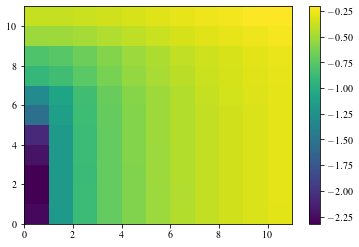

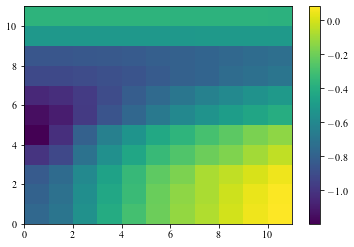

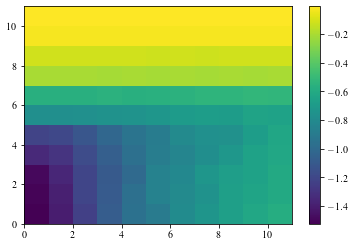

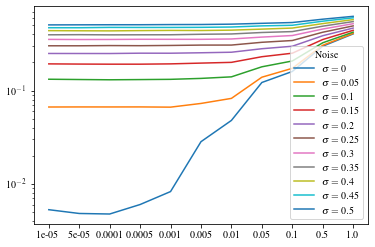

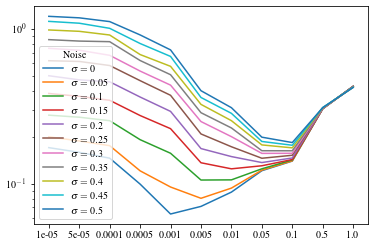

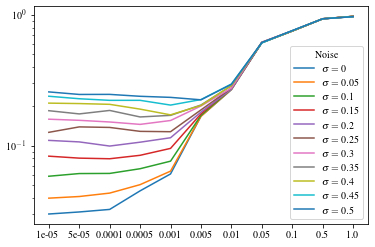

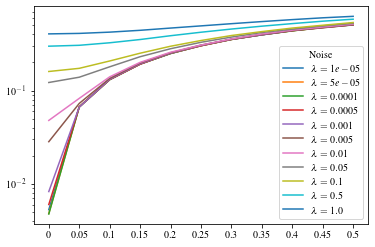

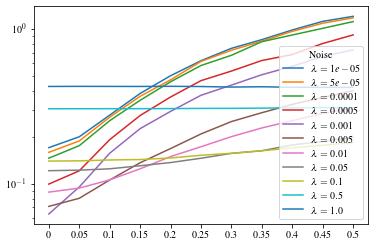

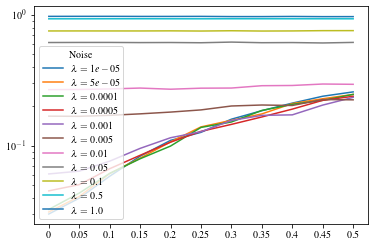

In [8]:
sigma_lmbda_res_mean = np.mean(sigma_lmbda_res, axis=2)
sigma_lmbda_G_res_mean = np.mean(sigma_lmbda_G_res, axis=2)
sigma_lmbda_beta_res_mean = np.mean(sigma_lmbda_beta_res, axis=2)

plt.pcolormesh(np.log10(sigma_lmbda_res_mean).T)
plt.colorbar()
plt.show()

plt.pcolormesh(np.log10(sigma_lmbda_G_res_mean).T)
plt.colorbar()
plt.show()

plt.pcolormesh(np.log10(sigma_lmbda_beta_res_mean).T)
plt.colorbar()
plt.show()

plt.plot(sigma_lmbda_res_mean.T)
plt.gca().set_xticks(np.arange(len(lmbdas)))
plt.gca().set_xticklabels(lmbdas)
plt.legend([f"$\sigma = {sigma}$" for sigma in sigmas], title="Noise")
plt.yscale("log")
plt.show()

plt.plot(sigma_lmbda_G_res_mean.T)
plt.gca().set_xticks(np.arange(len(lmbdas)))
plt.gca().set_xticklabels(lmbdas)
plt.legend([f"$\sigma = {sigma}$" for sigma in sigmas], title="Noise")
plt.yscale("log")
plt.show()

plt.plot(sigma_lmbda_beta_res_mean.T)
plt.gca().set_xticks(np.arange(len(lmbdas)))
plt.gca().set_xticklabels(lmbdas)
plt.legend([f"$\sigma = {sigma}$" for sigma in sigmas], title="Noise")
plt.yscale("log")
plt.show()

plt.plot(sigma_lmbda_res_mean)
plt.gca().set_xticks(np.arange(len(sigmas)))
plt.gca().set_xticklabels(sigmas)
plt.legend([f"$\lambda = {lmbda}$" for lmbda in lmbdas], title="Noise")
plt.yscale("log")
plt.show()

plt.plot(sigma_lmbda_G_res_mean)
plt.gca().set_xticks(np.arange(len(sigmas)))
plt.gca().set_xticklabels(sigmas)
plt.legend([f"$\lambda = {lmbda}$" for lmbda in lmbdas], title="Noise")
plt.yscale("log")
plt.show()

plt.plot(sigma_lmbda_beta_res_mean)
plt.gca().set_xticks(np.arange(len(sigmas)))
plt.gca().set_xticklabels(sigmas)
plt.legend([f"$\lambda = {lmbda}$" for lmbda in lmbdas], title="Noise")
plt.yscale("log")
plt.show()

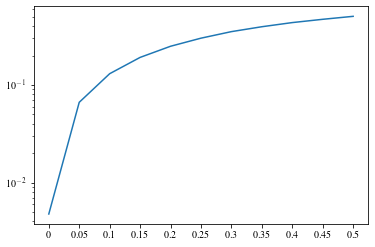

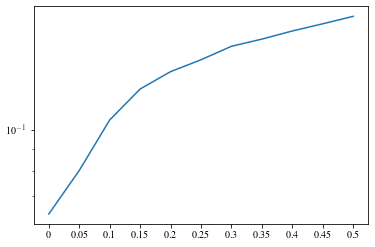

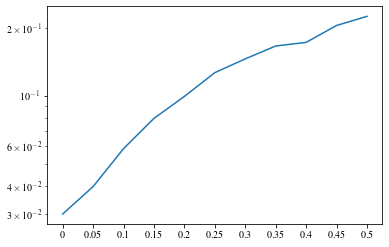

In [9]:
plt.plot(np.nanmin(sigma_lmbda_res_mean, axis=1))
plt.gca().set_xticks(np.arange(len(sigmas)))
plt.gca().set_xticklabels(sigmas)
plt.yscale("log")
plt.show()

plt.plot(np.nanmin(sigma_lmbda_G_res_mean, axis=1))
plt.gca().set_xticks(np.arange(len(sigmas)))
plt.gca().set_xticklabels(sigmas)
plt.yscale("log")
plt.show()

plt.plot(np.nanmin(sigma_lmbda_beta_res_mean, axis=1))
plt.gca().set_xticks(np.arange(len(sigmas)))
plt.gca().set_xticklabels(sigmas)
plt.yscale("log")
plt.show()

In [15]:
greens_weight_parametrizations = [] #[Symmetric((mx_weight, mx_weight), 0, 1)]

# Vary amount of training data
ns = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

trials = 10

n_res = np.zeros((len(ns), trials))
n_G_res = np.zeros((len(ns), trials))
n_beta_res = np.zeros((len(ns), trials))

n_greens_functions = np.empty((len(ns), trials), dtype=object)
n_bias_terms = np.empty((len(ns), trials), dtype=object)

if os.path.isfile("helmholtz_vs_n/hemlholtz_vs_n_res.npz"):
    results = np.load("helmholtz_vs_n/hemlholtz_vs_n_res.npz")
    n_res = results["n_res"]
    n_G_res = results["n_G_res"]
    n_beta_res = results["n_beta_res"]

kernel_width = 2e-2
lmbda = 1e-5
m = 100

fs_train = data[f"mesh{m}"][f"kernelwidth{kernel_width_train}"]["forcings"][:]
us_train_clean = data[f"mesh{m}"][f"kernelwidth{kernel_width_train}"]["solutions"][:]

fs_train = torch.from_numpy(fs_train).type(tensor)
us_train_clean = torch.from_numpy(us_train_clean).type(tensor)

for i in range(len(ns)):
    n = ns[i]
    for j in range(trials):
        print(f"({i}, {j})")
        if os.path.isfile(f"helmholtz_vs_n/n_bias_term_{i}_{j}.pkl"):
                continue
        
        fs = fs_train[n*j:n*(j+1), :]
        us = us_train_clean[n*j:n*(j+1), :]
        n_greens_functions[i, j], n_bias_terms[i, j], _, _, res, G_res, beta_res, G_norms, beta_norms = \
            train_rkhs_pde(fs, us, ind_divisor, kernel, kernel_width,
                           greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                           bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, beta_true=beta_true,
                           greens_lmbda=lmbda, bias_lmbda=lmbda,
                           batch_size=batch_size, epochs=epochs,
                           #greens_learning_rate=learning_rate, bias_learning_rate=learning_rate,
                           greens_weight_parametrizations=greens_weight_parametrizations, bias_weight_parametrizations=bias_weight_parametrizations,
                           greens_transform_output=greens_transform_output, bias_transform_output=bias_transform_output,
                           plotting_function=None, plotting_freq=plotting_freq, verbal=False)
        
        best_ind = np.argmin(res)
        n_res[i, j] = res[best_ind]
        n_G_res[i, j] = G_res[best_ind]
        n_beta_res[i, j] = beta_res[best_ind]
        
        np.savez("helmholtz_vs_n/hemlholtz_vs_n_res.npz", n_res=n_res, n_G_res=n_G_res, n_beta_res=n_beta_res)
        torch.save(n_greens_functions[i, j].state_dict(), f"helmholtz_vs_n/n_greens_function_{i}_{j}.pkl")
        torch.save(n_bias_terms[i, j].state_dict(), f"helmholtz_vs_n/n_bias_term_{i}_{j}.pkl")


(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)


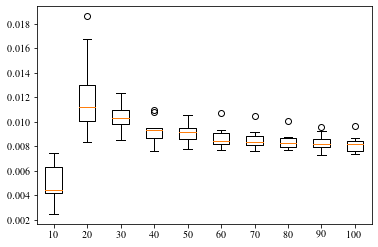

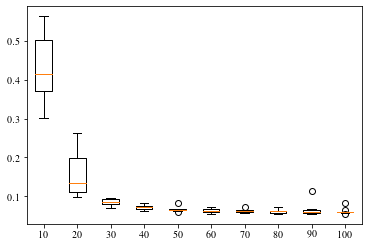

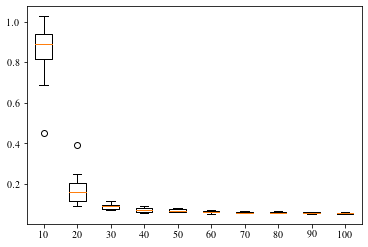

In [16]:
ns = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
results = np.load("helmholtz_vs_n/hemlholtz_vs_n_res.npz")
n_res = results["n_res"]
n_G_res = results["n_G_res"]
n_beta_res = results["n_beta_res"]

fig, ax = plt.subplots()
plt.boxplot(n_res.T)
plt.gca().set_xticklabels(ns)
plt.show()

fig, ax = plt.subplots()
plt.boxplot(n_G_res.T)
plt.gca().set_xticklabels(ns)
plt.show()

fig, ax = plt.subplots()
plt.boxplot(n_beta_res.T)
plt.gca().set_xticklabels(ns)
plt.show()

In [17]:
# Vary amount of measurement points
ms = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

trials = 10

m_res = np.zeros((len(ms), trials))
m_G_res = np.zeros((len(ms), trials))
m_beta_res = np.zeros((len(ms), trials))

m_greens_functions = np.empty((len(ms), trials), dtype=object)
m_bias_terms = np.empty((len(ms), trials), dtype=object)

if os.path.isfile("helmholtz_vs_m/hemlholtz_vs_m_res.npz"):
    results = np.load("helmholtz_vs_m/hemlholtz_vs_m_res.npz")
    m_res = results["m_res"]
    m_G_res = results["m_G_res"]
    m_beta_res = results["m_beta_res"]


kernel_width = 2e-2
lmbda = 1e-5

data = h5py.File("../../generate_data/helmholtz_gaussianKLE1D_dirbc_small.hdf5", "r")

for i in range(len(ns)):
    m = ms[i]
    fs_train = data[f"mesh{m}"][f"kernelwidth{kernel_width_train}"]["forcings"][:100, :]
    us_train_clean = data[f"mesh{m}"][f"kernelwidth{kernel_width_train}"]["solutions"][:100, :]

    fs_train = torch.from_numpy(fs_train).type(tensor)
    us_train_clean = torch.from_numpy(us_train_clean).type(tensor)
    
    x = torch.from_numpy(data[f"mesh{m}"].attrs["mesh"][0]).type(tensor)
    greens_out_meshes = (x, x)
    bias_out_meshes = (x,)

    for j in range(trials):
        print(f"({i}, {j})")
        if os.path.isfile(f"helmholtz_vs_m/m_bias_term_{i}_{j}.pkl"):
                continue
        
        m_greens_functions[i, j], m_bias_terms[i, j], _, _, res, G_res, beta_res, G_norms, beta_norms = \
            train_rkhs_pde(fs_train, us_train_clean, ind_divisor, kernel, kernel_width,
                           greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                           bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, beta_true=beta_true,
                           greens_lmbda=lmbda, bias_lmbda=lmbda,
                           batch_size=batch_size, epochs=epochs,
                           #greens_learning_rate=learning_rate, bias_learning_rate=learning_rate,
                           greens_weight_parametrizations=greens_weight_parametrizations, bias_weight_parametrizations=bias_weight_parametrizations,
                           greens_transform_output=greens_transform_output, bias_transform_output=bias_transform_output,
                           plotting_function=None, plotting_freq=plotting_freq, verbal=False)
        
        best_ind = np.argmin(res)
        m_res[i, j] = res[best_ind]
        m_G_res[i, j] = G_res[best_ind]
        m_beta_res[i, j] = beta_res[best_ind]
        
        np.savez("helmholtz_vs_m/hemlholtz_vs_m_res.npz", m_res=m_res, m_G_res=m_G_res, m_beta_res=m_beta_res)
        torch.save(m_greens_functions[i, j].state_dict(), f"helmholtz_vs_m/m_greens_function_{i}_{j}.pkl")
        torch.save(m_bias_terms[i, j].state_dict(), f"helmholtz_vs_m/m_bias_term_{i}_{j}.pkl")


(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)


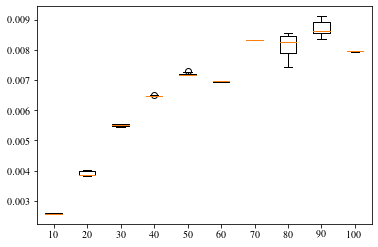

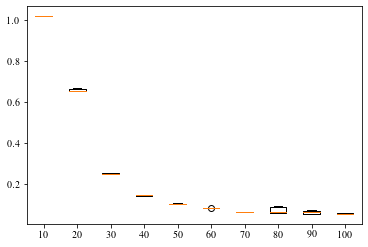

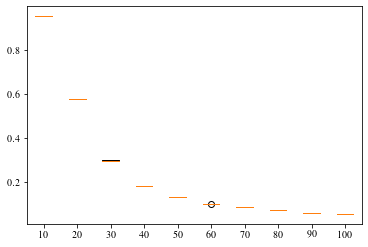

In [18]:
ms = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
results = np.load("helmholtz_vs_m/hemlholtz_vs_m_res.npz")
m_res = results["m_res"]
m_G_res = results["m_G_res"]
m_beta_res = results["m_beta_res"]

fig, ax = plt.subplots()
plt.boxplot(m_res.T)
plt.gca().set_xticklabels(ms)
plt.show()

fig, ax = plt.subplots()
plt.boxplot(m_G_res.T)
plt.gca().set_xticklabels(ms)
plt.show()

fig, ax = plt.subplots()
plt.boxplot(m_beta_res.T)
plt.gca().set_xticklabels(ms)
plt.show()

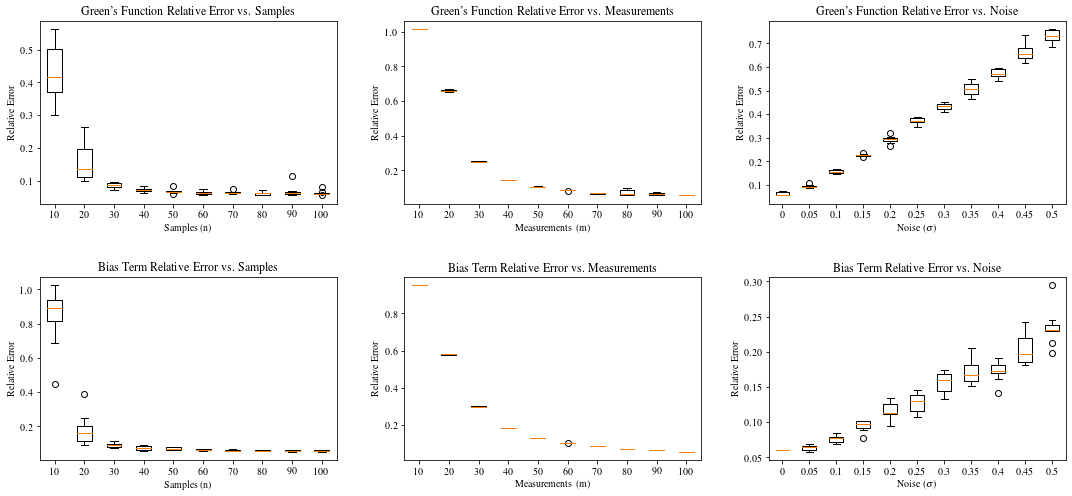

In [20]:
ns = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

results = np.load("helmholtz_vs_n/hemlholtz_vs_n_res.npz")
n_res = results["n_res"]
n_G_res = results["n_G_res"]
n_beta_res = results["n_beta_res"]

ms = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

results = np.load("helmholtz_vs_m/hemlholtz_vs_m_res.npz")
m_res = results["m_res"]
m_G_res = results["m_G_res"]
m_beta_res = results["m_beta_res"]

sigmas = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
lmbdas = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0]
results = np.load("helmholtz_vs_sigma_lmbda/hemlholtz_vs_sigma_lmbda_res.npz")
sigma_lmbda_res = results["sigma_lmbda_res"]
sigma_lmbda_G_res = results["sigma_lmbda_G_res"]
sigma_lmbda_beta_res = results["sigma_lmbda_beta_res"]

fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].boxplot(n_G_res.T)
axs[0, 0].set_xlabel("Samples (n)")
axs[0, 0].set_ylabel("Relative Error")
axs[0, 0].set_xticks(np.arange(1, len(ns)+1))
axs[0, 0].set_xticklabels(ns)
axs[0, 0].set_title("Green's Function Relative Error vs. Samples")

axs[0, 1].boxplot(m_G_res.T)
axs[0, 1].set_xlabel("Measurements (m)")
axs[0, 1].set_ylabel("Relative Error")
axs[0, 1].set_xticks(np.arange(1, len(ms)+1))
axs[0, 1].set_xticklabels(ms)
axs[0, 1].set_title("Green's Function Relative Error vs. Measurements")

axs[0, 2].boxplot(sigma_lmbda_G_res[:, 4, :].T)
axs[0, 2].set_xlabel("Noise ($\sigma$)")
axs[0, 2].set_ylabel("Relative Error")
axs[0, 2].set_xticks(np.arange(1, len(sigmas)+1))
axs[0, 2].set_xticklabels(sigmas)
axs[0, 2].set_title("Green's Function Relative Error vs. Noise")

axs[1, 0].boxplot(n_beta_res.T)
axs[1, 0].set_xlabel("Samples (n)")
axs[1, 0].set_ylabel("Relative Error")
axs[1, 0].set_xticks(np.arange(1, len(ns)+1))
axs[1, 0].set_xticklabels(ns)
axs[1, 0].set_title("Bias Term Relative Error vs. Samples")

axs[1, 1].boxplot(m_beta_res.T)
axs[1, 1].set_xlabel("Measurements (m)")
axs[1, 1].set_ylabel("Relative Error")
axs[1, 1].set_xticks(np.arange(1, len(ms)+1))
axs[1, 1].set_xticklabels(ms)
axs[1, 1].set_title("Bias Term Relative Error vs. Measurements")

axs[1, 2].boxplot(sigma_lmbda_beta_res[:, 4, :].T)
axs[1, 2].set_xlabel("Noise ($\sigma$)")
axs[1, 2].set_ylabel("Relative Error")
axs[1, 2].set_xticks(np.arange(1, len(sigmas)+1))
axs[1, 2].set_xticklabels(sigmas)
axs[1, 2].set_title("Bias Term Relative Error vs. Noise")

fig.tight_layout(h_pad=3, w_pad=3)
plt.savefig("../../figures/helmholtz_n_m_sigma.png", bbox_inches="tight")
plt.show()

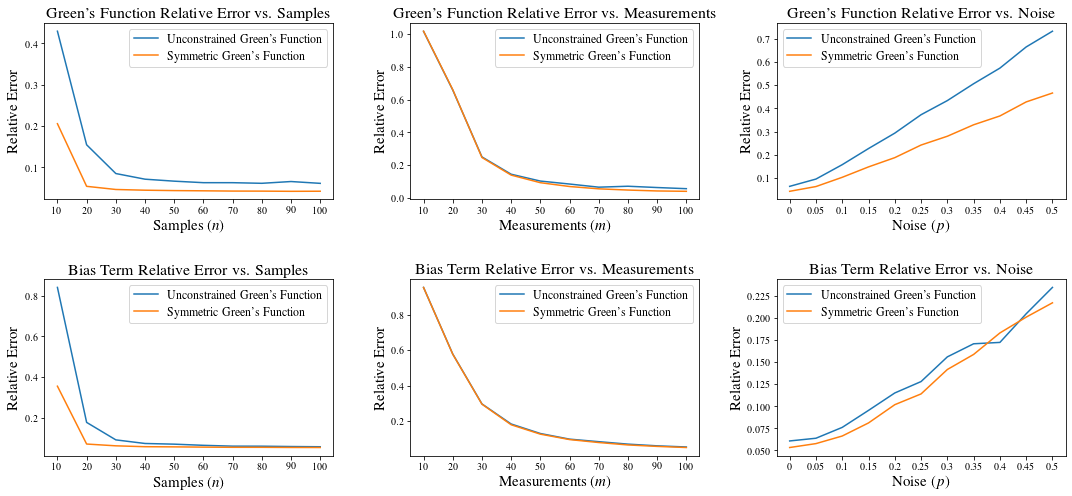

In [8]:
ns = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
results = np.load("helmholtz_vs_n/hemlholtz_vs_n_res.npz")
n_res = results["n_res"]
n_G_res = results["n_G_res"]
n_beta_res = results["n_beta_res"]

results = np.load("helmholtz_vs_n_symmetric/hemlholtz_vs_n_res.npz")
n_res_symm = results["n_res"]
n_G_res_symm = results["n_G_res"]
n_beta_res_symm = results["n_beta_res"]

ms = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
results = np.load("helmholtz_vs_m/hemlholtz_vs_m_res.npz")
m_res = results["m_res"]
m_G_res = results["m_G_res"]
m_beta_res = results["m_beta_res"]

results = np.load("helmholtz_vs_m_symmetric/hemlholtz_vs_m_res.npz")
m_res_symm = results["m_res"]
m_G_res_symm = results["m_G_res"]
m_beta_res_symm = results["m_beta_res"]

sigmas = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
lmbdas = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0]
results = np.load("helmholtz_vs_sigma_lmbda/hemlholtz_vs_sigma_lmbda_res.npz")
sigma_lmbda_res = results["sigma_lmbda_res"]
sigma_lmbda_G_res = results["sigma_lmbda_G_res"]
sigma_lmbda_beta_res = results["sigma_lmbda_beta_res"]

results = np.load("helmholtz_vs_sigma_lmbda_symmetric/hemlholtz_vs_sigma_lmbda_res.npz")
sigma_lmbda_res_symm = results["sigma_lmbda_res"]
sigma_lmbda_G_res_symm = results["sigma_lmbda_G_res"]
sigma_lmbda_beta_res_symm = results["sigma_lmbda_beta_res"]

fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].plot(np.mean(n_G_res, axis=1))
axs[0, 0].plot(np.mean(n_G_res_symm, axis=1))
axs[0, 0].set_xlabel("Samples ($n$)", fontsize=15)
axs[0, 0].set_ylabel("Relative Error", fontsize=15)
axs[0, 0].set_xticks(np.arange(len(ns)))
axs[0, 0].set_xticklabels(ns)
axs[0, 0].set_title("Green's Function Relative Error vs. Samples", fontsize=16)
axs[0, 0].legend(["Unconstrained Green's Function", "Symmetric Green's Function"], fontsize=12)

axs[0, 1].plot(np.mean(m_G_res, axis=1))
axs[0, 1].plot(np.mean(m_G_res_symm, axis=1))
axs[0, 1].set_xlabel("Measurements ($m$)", fontsize=15)
axs[0, 1].set_ylabel("Relative Error", fontsize=15)
axs[0, 1].set_xticks(np.arange(len(ms)))
axs[0, 1].set_xticklabels(ms)
axs[0, 1].set_title("Green's Function Relative Error vs. Measurements", fontsize=16)
axs[0, 1].legend(["Unconstrained Green's Function", "Symmetric Green's Function"], fontsize=12)

axs[0, 2].plot(np.mean(sigma_lmbda_G_res[:, 4, :], axis=1))
axs[0, 2].plot(np.mean(sigma_lmbda_G_res_symm[:, 4, :], axis=1))
axs[0, 2].set_xlabel("Noise ($p$)", fontsize=15)
axs[0, 2].set_ylabel("Relative Error", fontsize=15)
axs[0, 2].set_xticks(np.arange(len(sigmas)))
axs[0, 2].set_xticklabels(sigmas)
axs[0, 2].set_title("Green's Function Relative Error vs. Noise", fontsize=16)
axs[0, 2].legend(["Unconstrained Green's Function", "Symmetric Green's Function"], fontsize=12)

axs[1, 0].plot(np.mean(n_beta_res, axis=1))
axs[1, 0].plot(np.mean(n_beta_res_symm, axis=1))
axs[1, 0].set_xlabel("Samples ($n$)", fontsize=15)
axs[1, 0].set_ylabel("Relative Error", fontsize=15)
axs[1, 0].set_xticks(np.arange(len(ns)))
axs[1, 0].set_xticklabels(ns)
axs[1, 0].set_title("Bias Term Relative Error vs. Samples", fontsize=16)
axs[1, 0].legend(["Unconstrained Green's Function", "Symmetric Green's Function"], fontsize=12)

axs[1, 1].plot(np.mean(m_beta_res, axis=1))
axs[1, 1].plot(np.mean(m_beta_res_symm, axis=1))
axs[1, 1].set_xlabel("Measurements ($m$)", fontsize=15)
axs[1, 1].set_ylabel("Relative Error", fontsize=15)
axs[1, 1].set_xticks(np.arange(len(ms)))
axs[1, 1].set_xticklabels(ms)
axs[1, 1].set_title("Bias Term Relative Error vs. Measurements", fontsize=16)
axs[1, 1].legend(["Unconstrained Green's Function", "Symmetric Green's Function"], fontsize=12)

axs[1, 2].plot(np.mean(sigma_lmbda_beta_res[:, 4, :], axis=1))
axs[1, 2].plot(np.mean(sigma_lmbda_beta_res_symm[:, 4, :], axis=1))
axs[1, 2].set_xlabel("Noise ($p$)", fontsize=15)
axs[1, 2].set_ylabel("Relative Error", fontsize=15)
axs[1, 2].set_xticks(np.arange(len(sigmas)))
axs[1, 2].set_xticklabels(sigmas)
axs[1, 2].set_title("Bias Term Relative Error vs. Noise", fontsize=16)
axs[1, 2].legend(["Unconstrained Green's Function", "Symmetric Green's Function"], fontsize=12)

fig.tight_layout(h_pad=3, w_pad=3)
plt.savefig("../../figures/helmholtz_n_m_sigma.png", bbox_inches="tight")
plt.show()

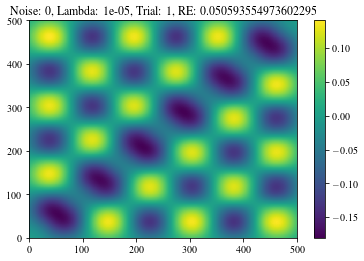

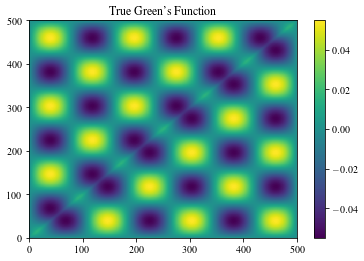

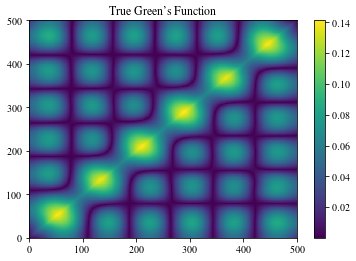

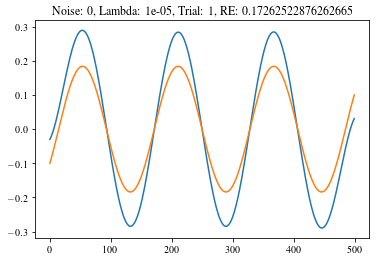

In [38]:
i = 0
j = 0
k = 0

greens_weight_parametrizations = []

greens_weight = torch.load(f"helmholtz_vs_sigma_lmbda/sigma_lmbda_greens_function_{i}_{j}_{k}.pkl")['weight']
greens_function = RKHSFunction(greens_out_meshes_true, greens_weight_meshes,
                                   kernel=kernel, sigma=kernel_width, dtype=torch.cuda.FloatTensor,
                                   weight_parametrizations=greens_weight_parametrizations,
                                   transform_output=greens_transform_output)
greens_function.weight = torch.nn.Parameter(greens_weight)
G = torch.reshape(greens_function(), (f_size_true, u_size_true))

bias_weight = torch.load(f"helmholtz_vs_sigma_lmbda/sigma_lmbda_bias_term_{i}_{j}_{k}.pkl")['weight']
bias_term = RKHSFunction(bias_out_meshes_true, bias_weight_meshes,
                                   kernel=kernel, sigma=kernel_width, dtype=torch.cuda.FloatTensor,
                                   weight_parametrizations=bias_weight_parametrizations,
                                   transform_output=bias_transform_output)
bias_term.weight = torch.nn.Parameter(bias_weight)
beta = torch.reshape(bias_term(), (u_size_true,))

plt.pcolormesh(G.cpu().detach())
plt.title(f"Noise: {sigmas[i]}, Lambda: {lmbdas[j]}, Trial: {k+1}, RE: {sigma_lmbda_G_res_symm[i, j, k]}")
plt.colorbar()
plt.show()

plt.pcolormesh(G_true.cpu().detach())
plt.title(f"True Green's Function")
plt.colorbar()
plt.show()

plt.pcolormesh(torch.abs(G - G_true).cpu().detach())
plt.title(f"True Green's Function")
plt.colorbar()
plt.show()

plt.plot(beta.cpu().detach())
plt.plot(beta_true.cpu().detach())
plt.title(f"Noise: {sigmas[i]}, Lambda: {lmbdas[j]}, Trial: {k+1}, RE: {sigma_lmbda_G_res[i, j, k]}")
plt.show()

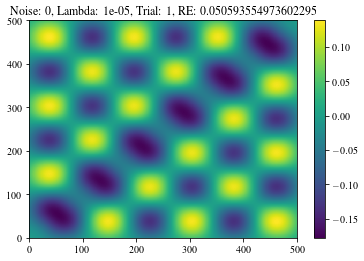

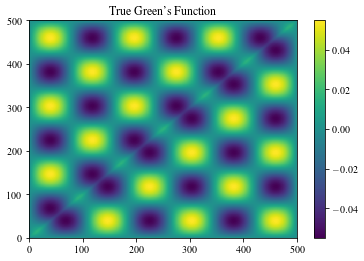

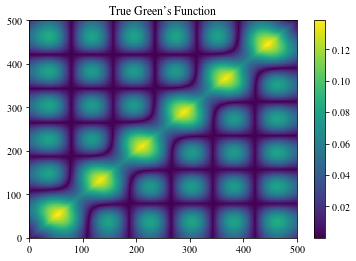

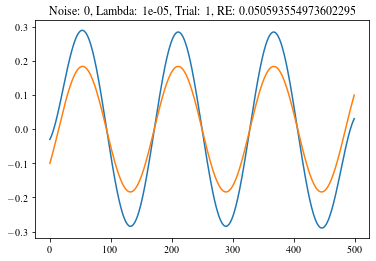

In [36]:
i = 0
j = 0
k = 0

greens_weight_parametrizations = [Symmetric((mx_weight, mx_weight), 0, 1)]

greens_weight = torch.load(f"helmholtz_vs_sigma_lmbda_symmetric/sigma_lmbda_greens_function_{i}_{j}_{k}.pkl")['parametrizations.weight.original']
greens_function = RKHSFunction(greens_out_meshes_true, greens_weight_meshes,
                                   kernel=kernel, sigma=kernel_width, dtype=torch.cuda.FloatTensor,
                                   weight_parametrizations=greens_weight_parametrizations,
                                   transform_output=greens_transform_output)
greens_function.parametrizations.weight.original = torch.nn.Parameter(greens_weight)
G = torch.reshape(greens_function(), (f_size_true, u_size_true))

bias_weight = torch.load(f"helmholtz_vs_sigma_lmbda_symmetric/sigma_lmbda_bias_term_{i}_{j}_{k}.pkl")['weight']
bias_term = RKHSFunction(bias_out_meshes_true, bias_weight_meshes,
                                   kernel=kernel, sigma=kernel_width, dtype=torch.cuda.FloatTensor,
                                   weight_parametrizations=bias_weight_parametrizations,
                                   transform_output=bias_transform_output)
bias_term.weight = torch.nn.Parameter(bias_weight)
beta = torch.reshape(bias_term(), (u_size_true,))

plt.pcolormesh(G.cpu().detach())
plt.title(f"Noise: {sigmas[i]}, Lambda: {lmbdas[j]}, Trial: {k+1}, RE: {sigma_lmbda_G_res_symm[i, j, k]}")
plt.colorbar()
plt.show()

plt.pcolormesh(G_true.cpu().detach())
plt.title(f"True Green's Function")
plt.colorbar()
plt.show()

plt.pcolormesh(torch.abs(G - G_true).cpu().detach())
plt.title(f"True Green's Function")
plt.colorbar()
plt.show()

plt.plot(beta.cpu().detach())
plt.plot(beta_true.cpu().detach())
plt.title(f"Noise: {sigmas[i]}, Lambda: {lmbdas[j]}, Trial: {k+1}, RE: {sigma_lmbda_G_res_symm[i, j, k]}")
plt.show()

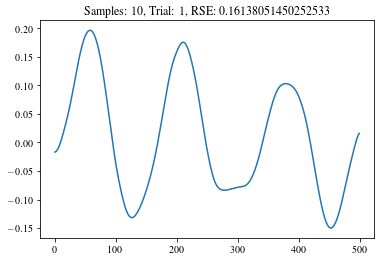

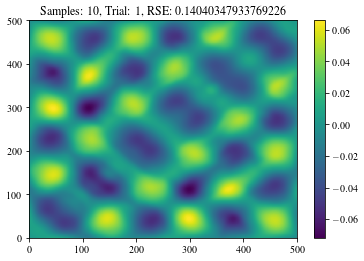

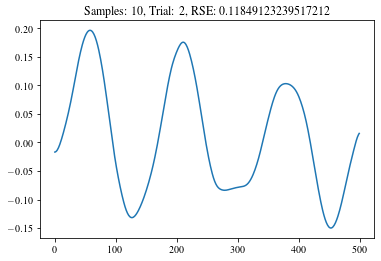

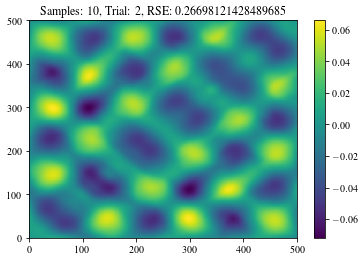

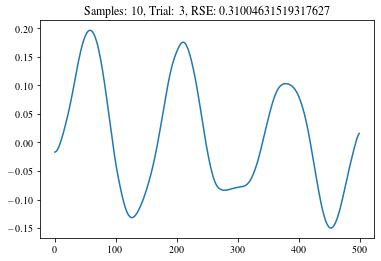

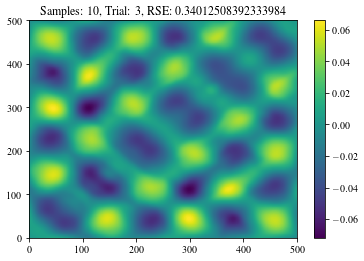

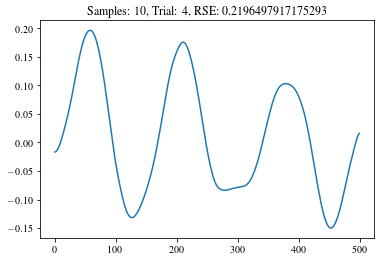

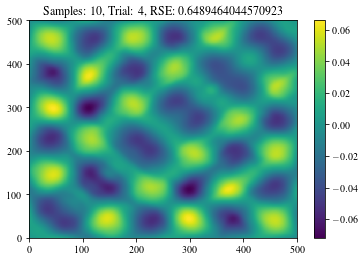

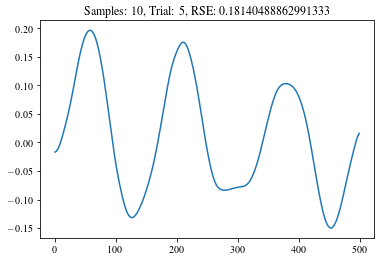

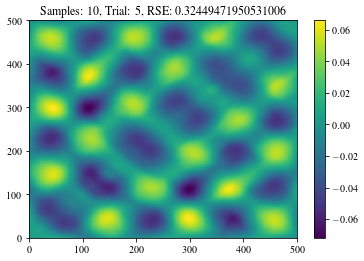

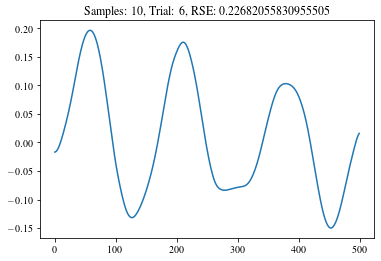

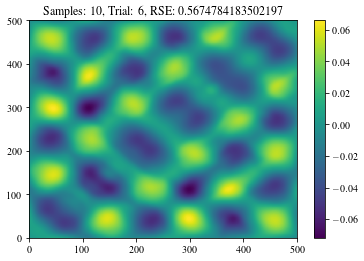

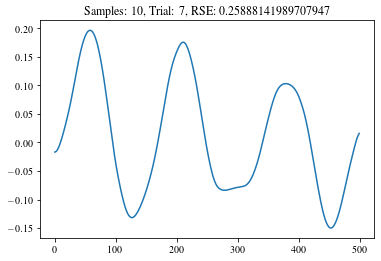

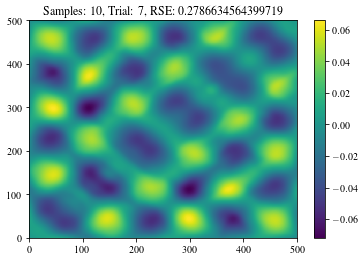

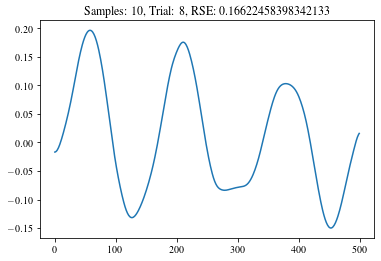

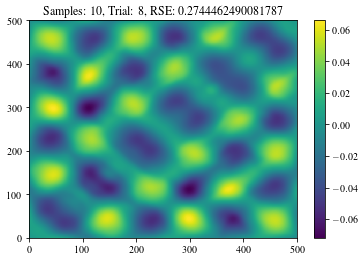

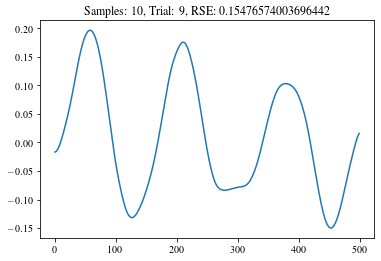

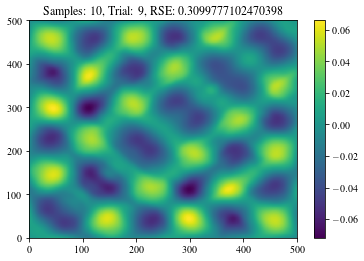

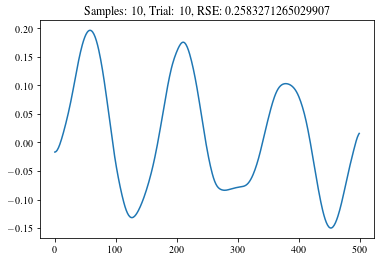

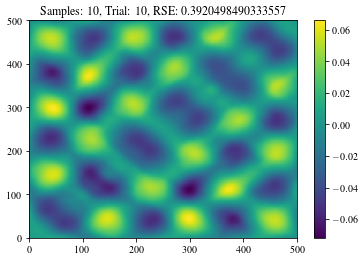

In [16]:
i = 0

for j in range(trials):
    n_greens_functions[i, j].update_mesh(greens_out_meshes_true)
    G = n_greens_functions[i, j]()
    G = torch.reshape(G, (f_size_true, u_size_true))
    
    n_bias_terms[i, j].update_mesh(bias_out_meshes_true)
    beta = n_bias_terms[i, j]()

    plt.plot(beta.cpu().detach())
    plt.title(f"Samples: {ns[i]}, Trial: {j+1}, RSE: {n_G_res[i, j]}")
    plt.show()

    plt.pcolormesh(G.cpu().detach())
    plt.title(f"Samples: {ns[i]}, Trial: {j+1}, RSE: {n_beta_res[i, j]}")
    plt.colorbar()
    plt.show()

In [17]:
G1 = n_greens_functions[0, 0]()
G1 = torch.reshape(G1, (f_size_true, u_size_true))

G2 = n_greens_functions[0, 1]()
G2 = torch.reshape(G2, (f_size_true, u_size_true))

In [18]:
torch.norm(G1 - G2)

tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)

In [ ]:
greens_function.update_mesh(greens_out_meshes)
G = greens_function()
G = torch.reshape(G, (f_size, u_size))

bias_term.update_mesh(bias_out_meshes)
beta = bias_term()

# get re for all examples in train set
us_train_hat = (fs_train * f_quadrature) @ G
if bias:
    us_train_hat += beta
train_res = relative_error(us_train_hat.cpu(), us_train_clean.cpu())

# interpolate Green's function and bias term to fine mesh
greens_function.update_mesh(greens_out_meshes_true)
G = greens_function()
G = torch.reshape(G, (f_size_true, u_size_true))

if bias:
    bias_term.update_mesh(bias_out_meshes_true)
    beta = bias_term()

# plot relative squared errors over iterations
plt.figure(2)
plt.title('Relative Squared Errors', fontweight='bold')
plt.plot(range(len(res)), res, label='Train re', zorder=2)
plt.plot(range(len(G_res)), G_res, label='$\widehat{G}$ re', zorder=1)
if bias:
    plt.plot(range(len(beta_res)), beta_res, label='$\widehat{\\beta}$ re', zorder=0)
plt.xlabel('Epochs')
plt.ylabel('Relative Train Error')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

# plot learned Green's function
vmin = torch.minimum(torch.min(G), torch.min(G_true)).item()
vmax = torch.maximum(torch.max(G), torch.max(G_true)).item()
plt.figure(3)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Predicted Green\'s Function $\widehat{G}(x, y)$', fontweight='bold')
axs[0].pcolormesh(x_true.cpu(), x_true.cpu(), G.cpu().detach(), shading='auto', vmin=vmin, vmax=vmax)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].set_title('True Green\'s Function $G(x, y)$', fontweight='bold')
im = axs[1].pcolormesh(x_true.cpu(), x_true.cpu(), G_true.cpu().detach(), shading='auto', vmin=vmin, vmax=vmax)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

cb_ax = fig.add_axes([1.0, 0.12, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_ticks(np.linspace(vmin, vmax, 10))
plt.tight_layout()
plt.show()

# plot learned bias term
if bias:
    plt.figure(4)
    plt.title('Predicted Bias Term $\widehat{\\beta}(y)$' + ' (re: {:.3E})'.format(beta_res[-1]), fontweight='bold')
    plt.plot(x_true.cpu(), beta_true.cpu().detach(), label='True $\\beta$')
    plt.plot(x_true.cpu(), beta.cpu().detach(), '--', label='Predicted $\widehat{\\beta}$')
    plt.xlabel('$y$')
    plt.legend(loc='upper right')
    plt.show()

# compute the relative train error on the solutions
train_re = res[-1]
print('Train Relative Squared Error: ' + str(train_re))

# plot best and worst case train predictions
best_re, best_ind = torch.min(train_res, 0)
worst_re, worst_ind = torch.max(train_res, 0)

plt.figure(5)
plt.title('Best Train Prediction (re: {:.3E})'.format(best_re), fontweight='bold')
plt.plot(x_train.cpu(), us_train_clean[best_ind, :].cpu())
plt.plot(x_train.cpu(), us_train_hat[best_ind, :].cpu().detach().numpy(), '--')
plt.xlabel('x')
plt.show()

plt.figure(6)
plt.title('Worst Train Prediction (re: {:.3E})'.format(worst_re), fontweight='bold')
plt.plot(x_train.cpu(), us_train_clean[worst_ind, :].cpu())
plt.plot(x_train.cpu(), us_train_hat[worst_ind, :].cpu().detach().numpy(), '--')
plt.xlabel('x')
plt.show()

In [ ]:
###############################################################################
#   Test Functional Neural Network on New Mesh Sizes
###############################################################################

# number of test samples
num_test = 1000

kernel_width_sizes = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0]
mesh_sizes = np.arange(100, 501, 50)

test_sigma = 0.0

test_mesh_res = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
for i in range(len(mesh_sizes)):
    for j in range(len(kernel_width_sizes)):
        print(f'({i}, {j})')
        m = mesh_sizes[i]
        w = kernel_width_sizes[j]

        x_test = data[f"mesh{m}"].attrs["mesh"][0]
        mx_test = len(x_test)

        fs_test = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][:, -num_test:].T
        us_test_clean = data[f"mesh{m}"][f"kernelwidth{w}"]["solutions"][:, -num_test:].T

        x_test = torch.from_numpy(x_test).type(tensor)
        fs_test = torch.from_numpy(fs_test)
        us_test_clean = torch.from_numpy(us_test_clean)

        # add noise to solutions at a given SNR
        us_test = us_test_clean + test_sigma * standard_deviation(us_test_clean) * torch.randn(num_test, mx_test)

        fs_test = fs_test.view(num_test, mx_test).type(tensor)
        us_test = us_test.view(num_test, mx_test).type(tensor)

        greens_function.update_mesh((x_test, x_test))
        G = greens_function()
        G = torch.reshape(G, (mx_test, mx_test))

        bias_term.update_mesh((x_test,))
        beta = bias_term()

        out_meshes = (x_test, x_test)
        f_quadrature = trapezoid_rule(out_meshes[:ind_divisor+1])
        us_test_hat = (fs_test * f_quadrature) @ G + beta
        test_re = relative_error(us_test_hat, us_test, agg="mean").item()
        test_mesh_res[i, j] = test_re

# plot test error of model on new test meshes
plt.figure(7)
plt.title('Relative Test Error (Trained on m = {})'.format(mx_train), y=1.05, fontweight='bold')
plt.pcolormesh(test_mesh_res.T)
plt.xlabel('Mesh Size (m)')
plt.ylabel('Kernel Width ($\sigma$)')
plt.colorbar()
plt.show()


# plot learned Green's function
plt.figure(3)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Predicted Green\'s Function $\widehat{G}(x, y)$', fontweight='bold')
axs[0].pcolormesh(x_test.cpu(), x_test.cpu(), G.cpu().detach(), shading='auto')
#plt.colorbar()
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].set_title('True Green\'s Function $G(x, y)$', fontweight='bold')
im = axs[1].pcolormesh(x_train.cpu(), x_train.cpu(), G_true.cpu().detach(), shading='auto')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

# plot best and worst case test predictions
test_res = relative_error(us_test_hat, us_test)
best_re, best_ind = torch.min(test_res, 0)
worst_re, worst_ind = torch.max(test_res, 0)

plt.figure(8)
plt.title('Best Test Prediction (re: {:.3E})'.format(best_re), fontweight='bold')
plt.plot(x_test.cpu(), us_test[best_ind, :].cpu().detach())
plt.plot(x_test.cpu(), us_test_hat[best_ind, :].cpu().detach(), '--')
plt.xlabel('x')
plt.show()

plt.figure(9)
plt.title('Worst Test Prediction (re: {:.3E})'.format(worst_re), fontweight='bold')
plt.plot(x_test.cpu(), us_test[worst_ind, :].cpu().detach())
plt.plot(x_test.cpu(), us_test_hat[worst_ind, :].cpu().detach(), '--')
plt.xlabel('x')
plt.show()

In [ ]:
plt.plot(test_mesh_res)
plt.show()

In [ ]:
plt.plot(test_mesh_res.T)
plt.show()